### Separate by life cycle phase

Variables with unclear trends:
- when I use t_since_LMI as x-axis and with vmax_LMI >= 50m/s: B, Rossby, and fcor
- when I use t_since_17kts as x-axis and with vmax_LMI >= 50m/s: none

There is a separation regime when t_since_17kts = 100 hours (which probably corresponds to the average LMI time). So, separate the dataset into three subsets (pre-LMI, post-LMI, near-LMI): t_since_17kts <= 100 hours, t_since_17kts >= 100 hours, and -24 hours <= t_since_LMI <= 24 hours. When I plot the structural (Vmax, Rmax, f, Rxx) and dynamical parameters (B, Rossby, Uc, R+, R0), this doesn't significantly change the results. So keep the plots with the composite.

CONCLUSION: Plot using t_since_17kts as x-axis. Color by t_LMI. No further need.

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
# import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/Tests/',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# Compute beta0
g  = 9.81  # m s-2
qb = 0.02  # kg/kg
L  = 2.5e6 # J/kg
Cp = 1e3   # J/kg/K
# dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.sst_pmd / (g * qb * L)
dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.temp_pmd / (g * qb * L)
dsg['beta0_T0'] = (dsg.uc ** 2) * Cp / (g * qb * L)

# # Rel SST
# dsg['rel_sst'] = dsg.sst_pmd - dsg.trop_sst_rms

# dK/dt
### Computing Kinetic Energy
V34         = 17.5 # m/s
g           = 9.8  # m/s^2
rho         = 1.15 # kg/m^3
theta_ratio = 1e-2 # []
# Below, dK/dt is expressed in J/hr, where 1J = 1 kg m^2 s^-2
dsg['dKdt'] = (rho * V34 ** 2 / (g * theta_ratio)) * 2 * (dsg['r34'] * dsg['vmx']) * ((dsg['vmx_dot_smth_ibt'] / 3600) * (dsg['r34']) + (dsg['r34_dot_smth_ibt'] * 1000 / 3600) * dsg['vmx'])
nrm         = 1e15
dsg['dKdt'] = dsg['dKdt'] / nrm # now in PJ/hr

# Group by basin
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016

for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0]

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [5]:
da = d.where(d.basin == 'al', drop=True)

Text(0, 0.5, 'Vmax (m/s')

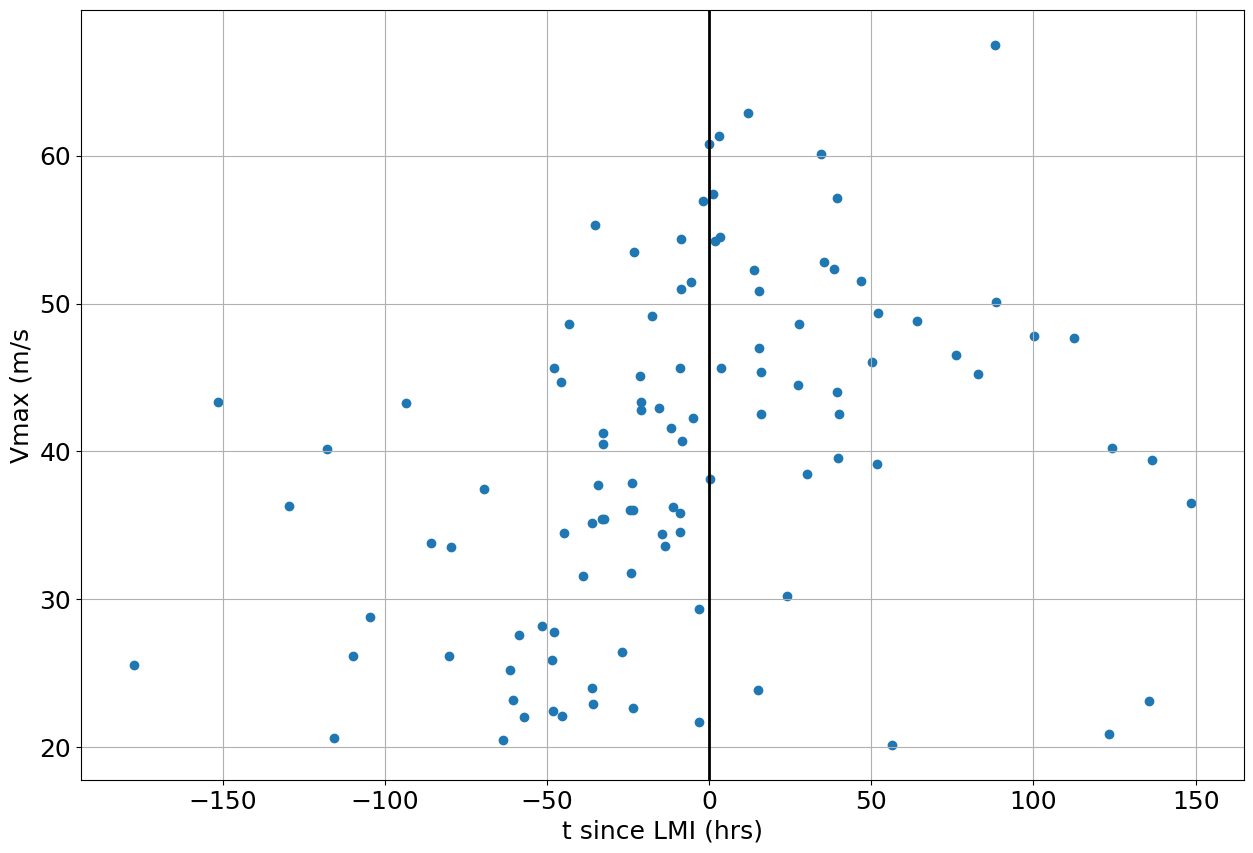

In [6]:
plt.scatter(da.t_since_lmi_ibt / 3600, da.vmx)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('Vmax (m/s')

### t since LMI

In [7]:
dplt = da.where(da.lmi_ibt >= 50, drop=True)

Text(0, 0.5, 'Vmax (m/s)')

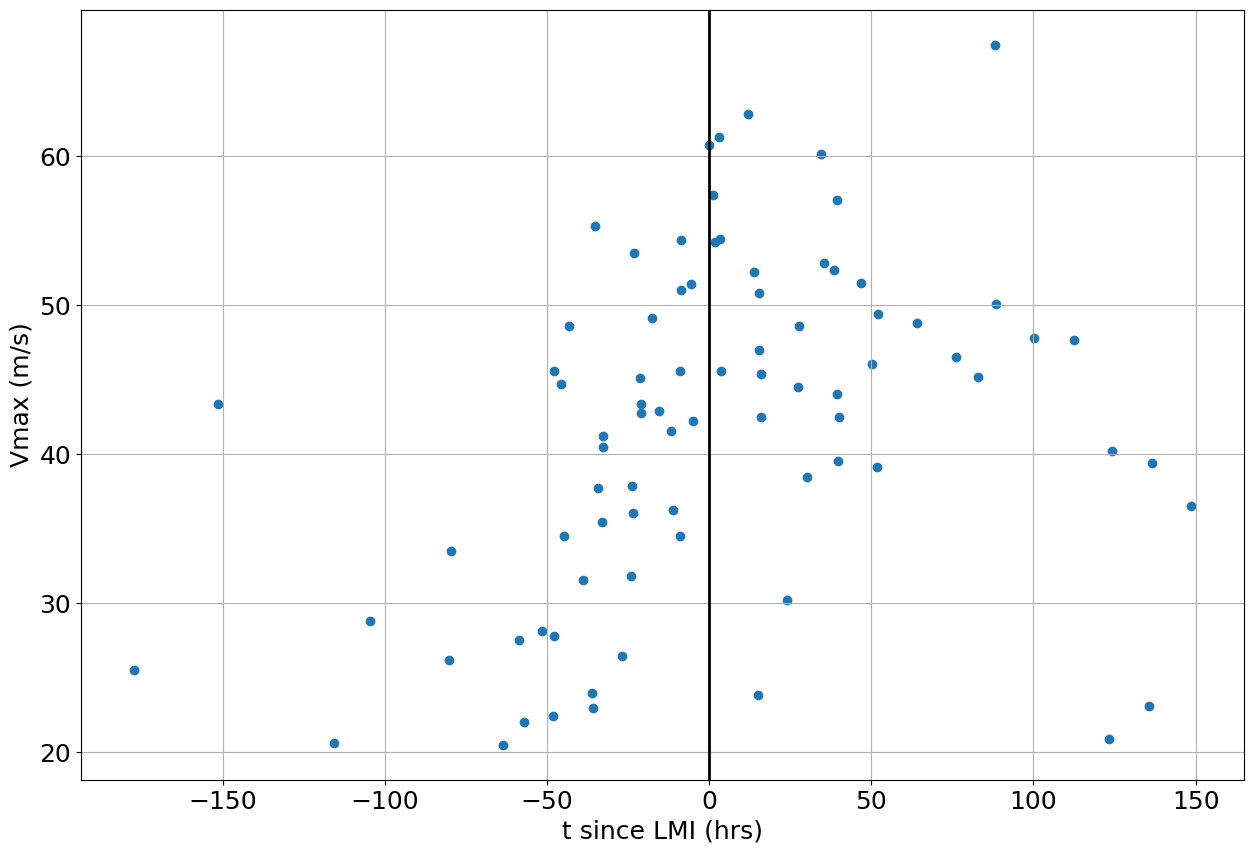

In [8]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.vmx)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('Vmax (m/s)')

Text(0, 0.5, 'Rmax (km)')

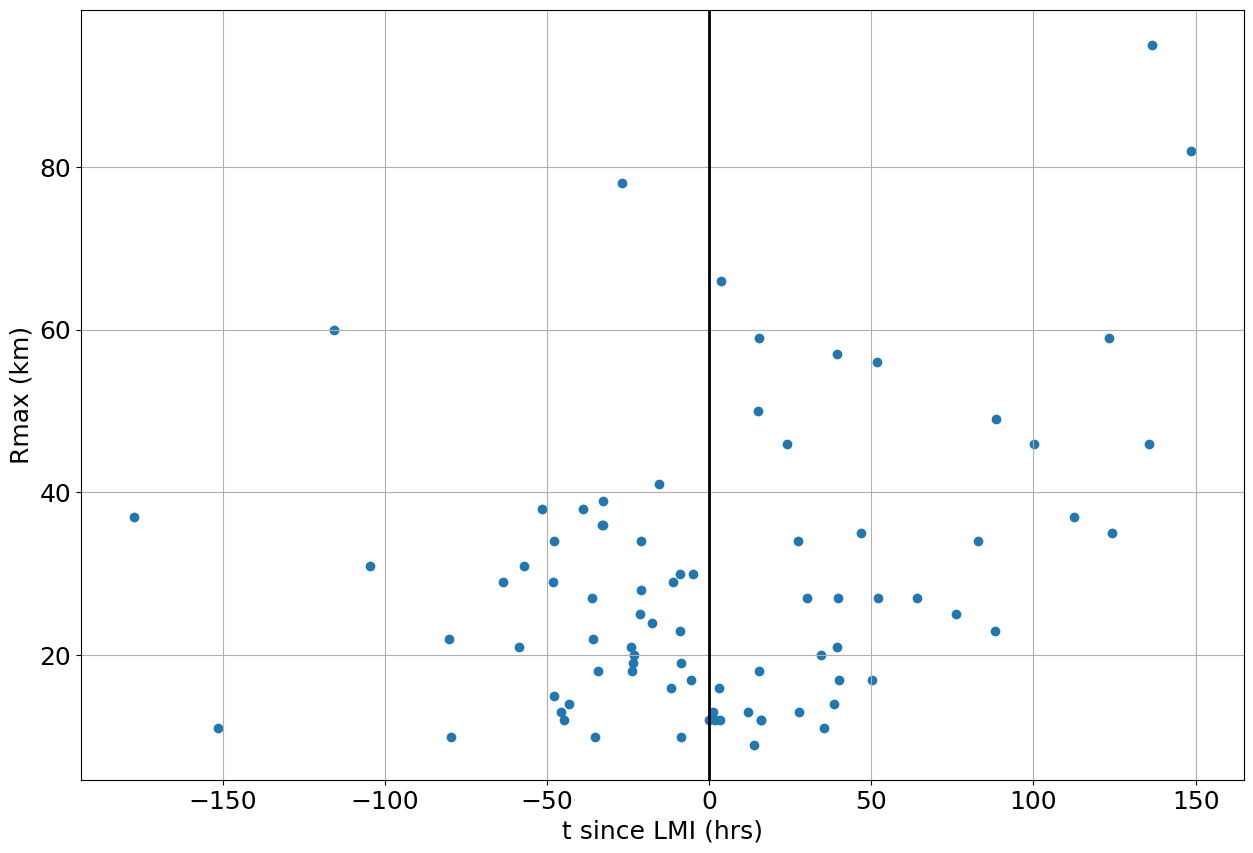

In [9]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.rmx / 1000)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('Rmax (km)')

Text(0, 0.5, 'fcor (s-1)')

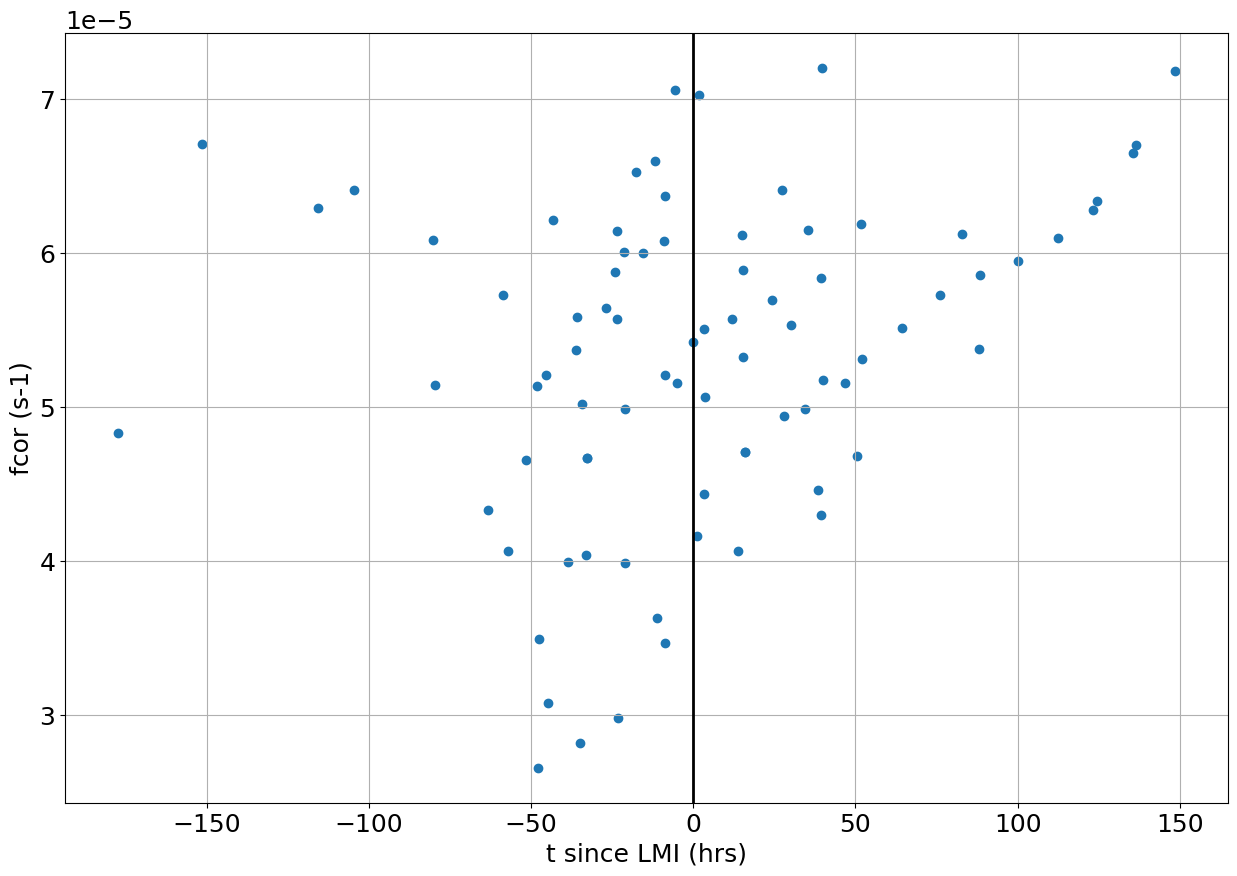

In [10]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, abs(dplt.fcor))
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('fcor (s-1)')

Text(0, 0.5, 'r34 (km)')

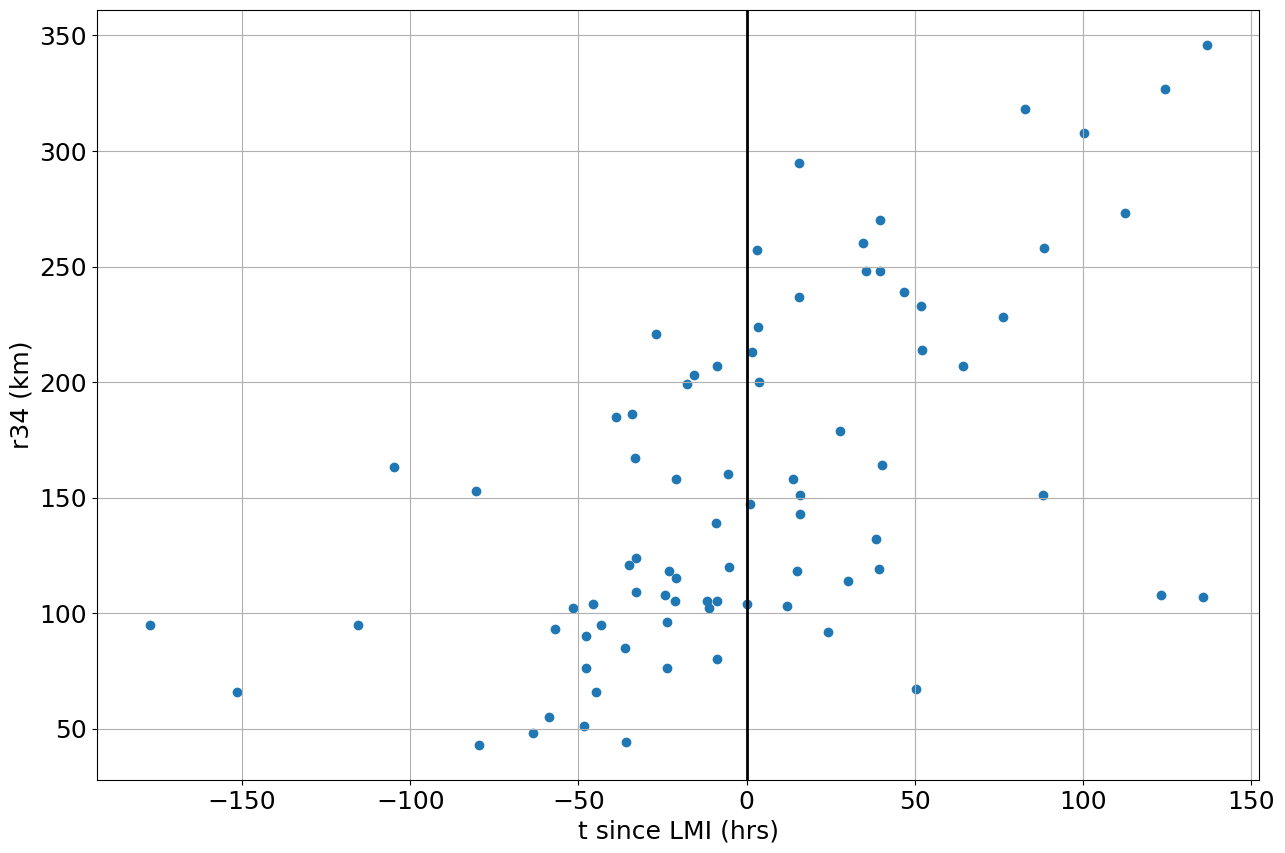

In [11]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.r34 / 1000)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('r34 (km)')

Text(0, 0.5, 'B')

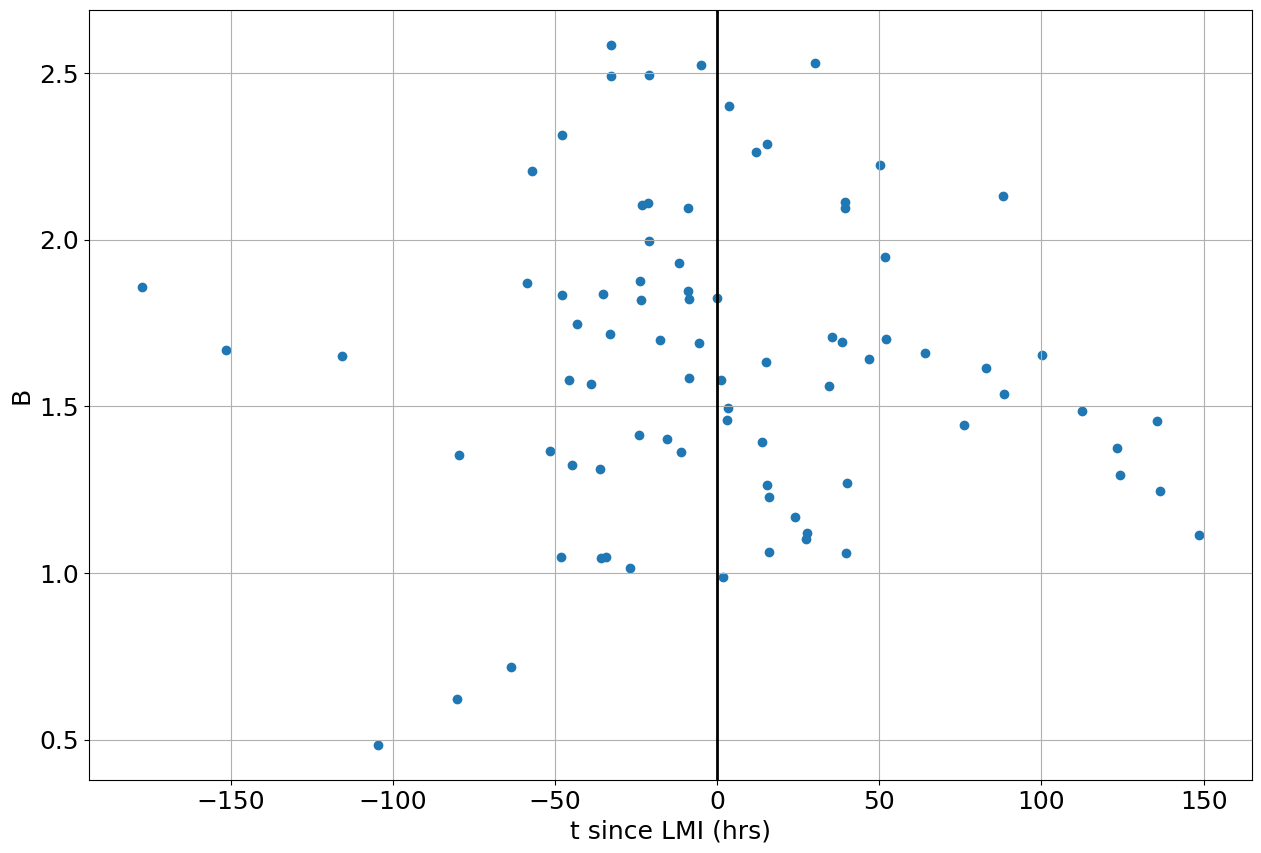

In [12]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.B_hol)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('B')

Text(0, 0.5, 'Rossby')

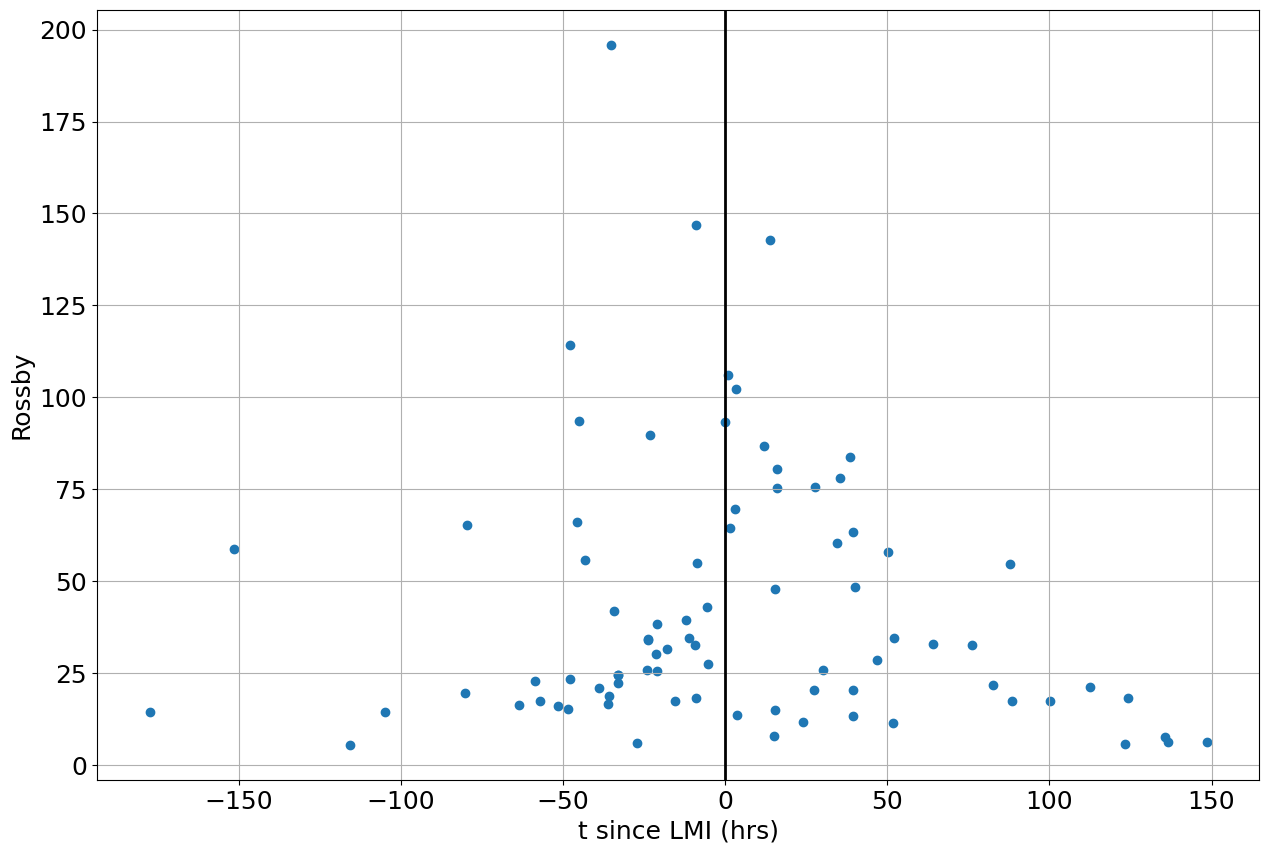

In [13]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.rsby)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('Rossby')

Text(0, 0.5, 'Uc (m/s)')

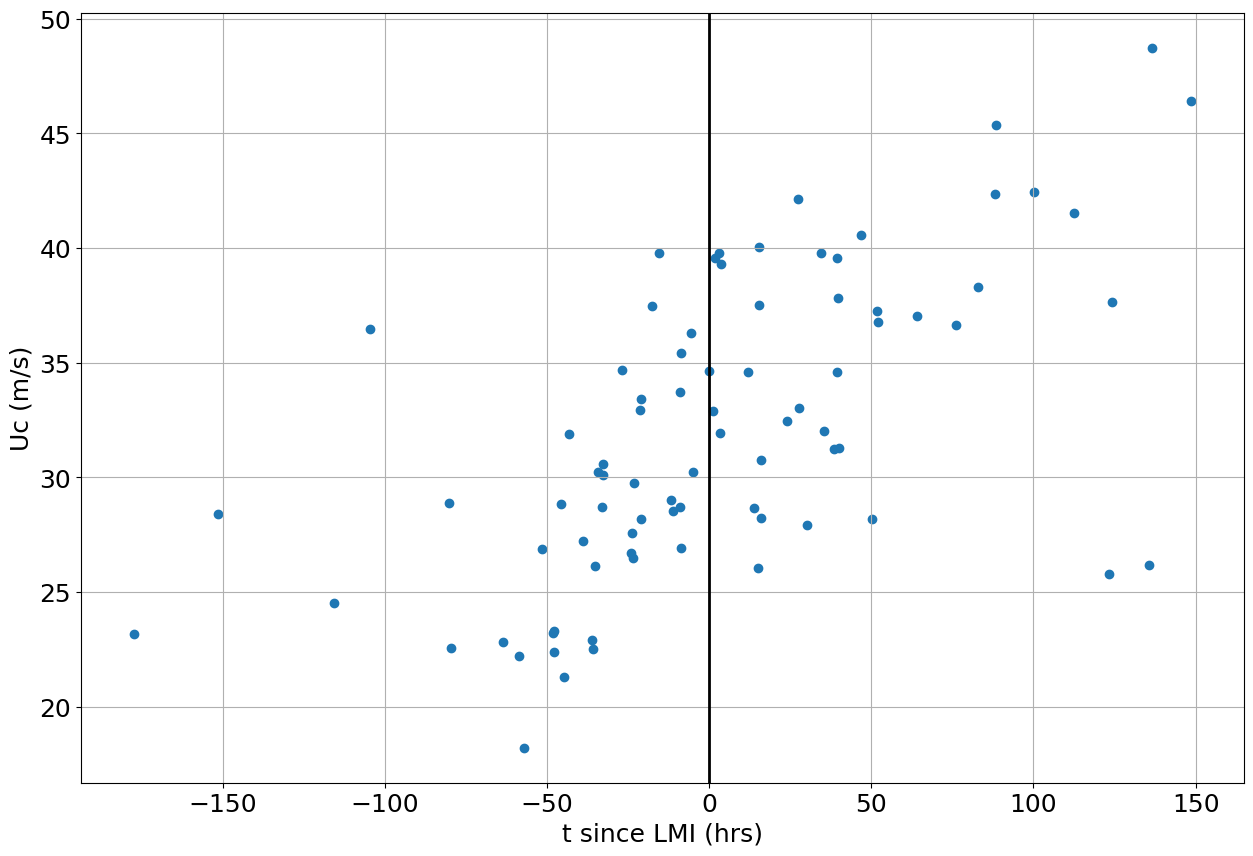

In [14]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.uc)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('Uc (m/s)')

Text(0, 0.5, 'R+ (km)')

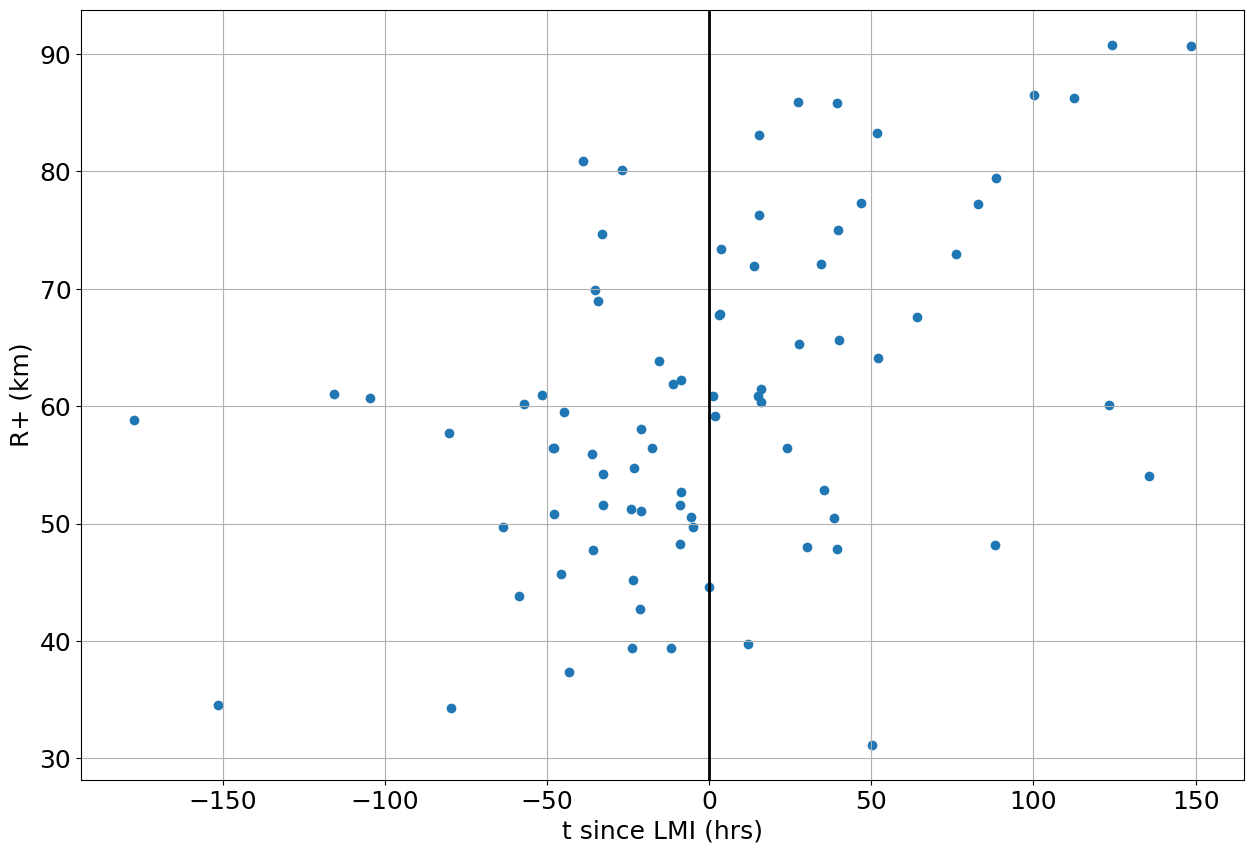

In [15]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.rps / 1000)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('R+ (km)')

Text(0, 0.5, 'R0 (km)')

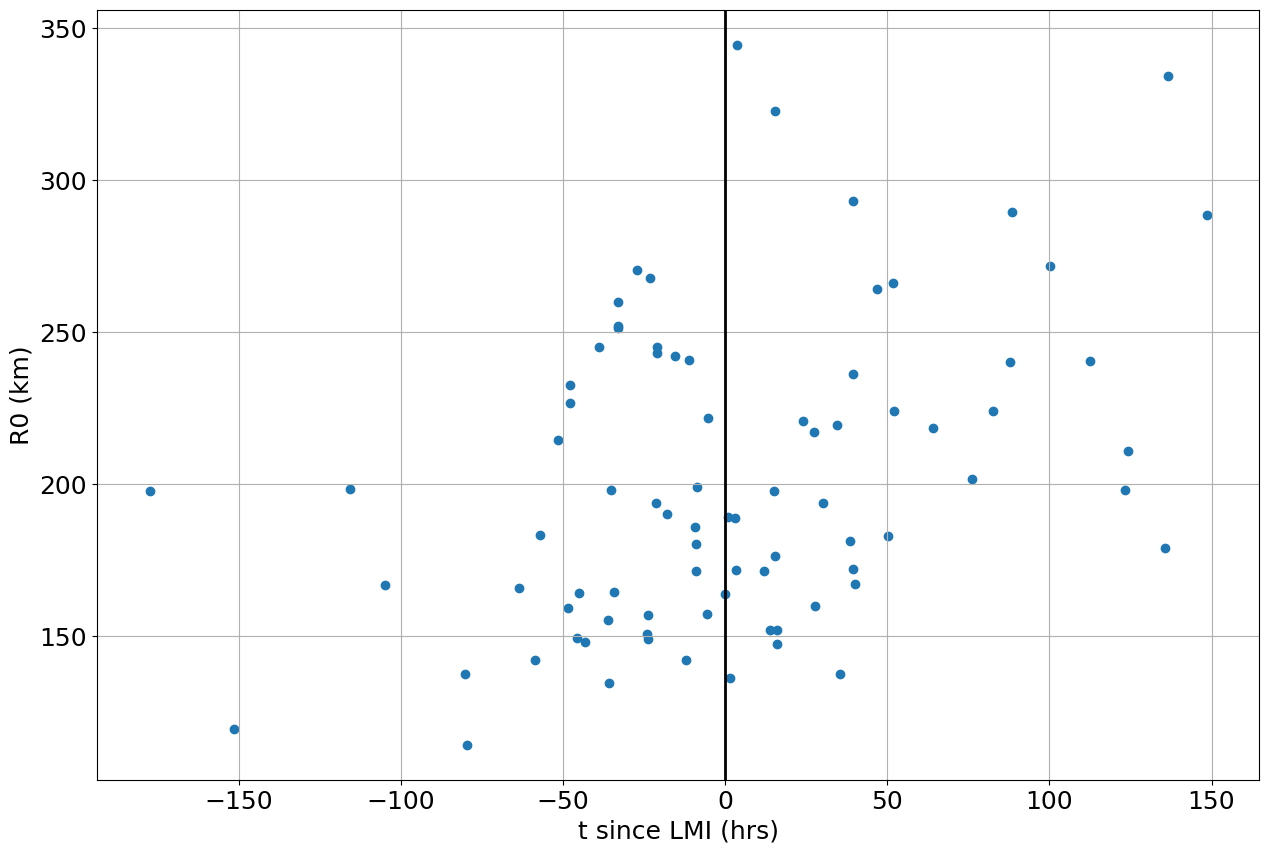

In [16]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.r0 / 1000)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('R0 (km)')

### t since 17 kts

In [17]:
dplt = da.where(da.lmi_ibt >= 50, drop=True)

In [18]:
dplt_lmi = dplt.where((dplt.t_since_lmi_ibt / 3600 >= -24) & (dplt.t_since_lmi_ibt / 3600 <= 24), drop=True)

/tmp/ipykernel_56593/1130418992.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.vmx, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


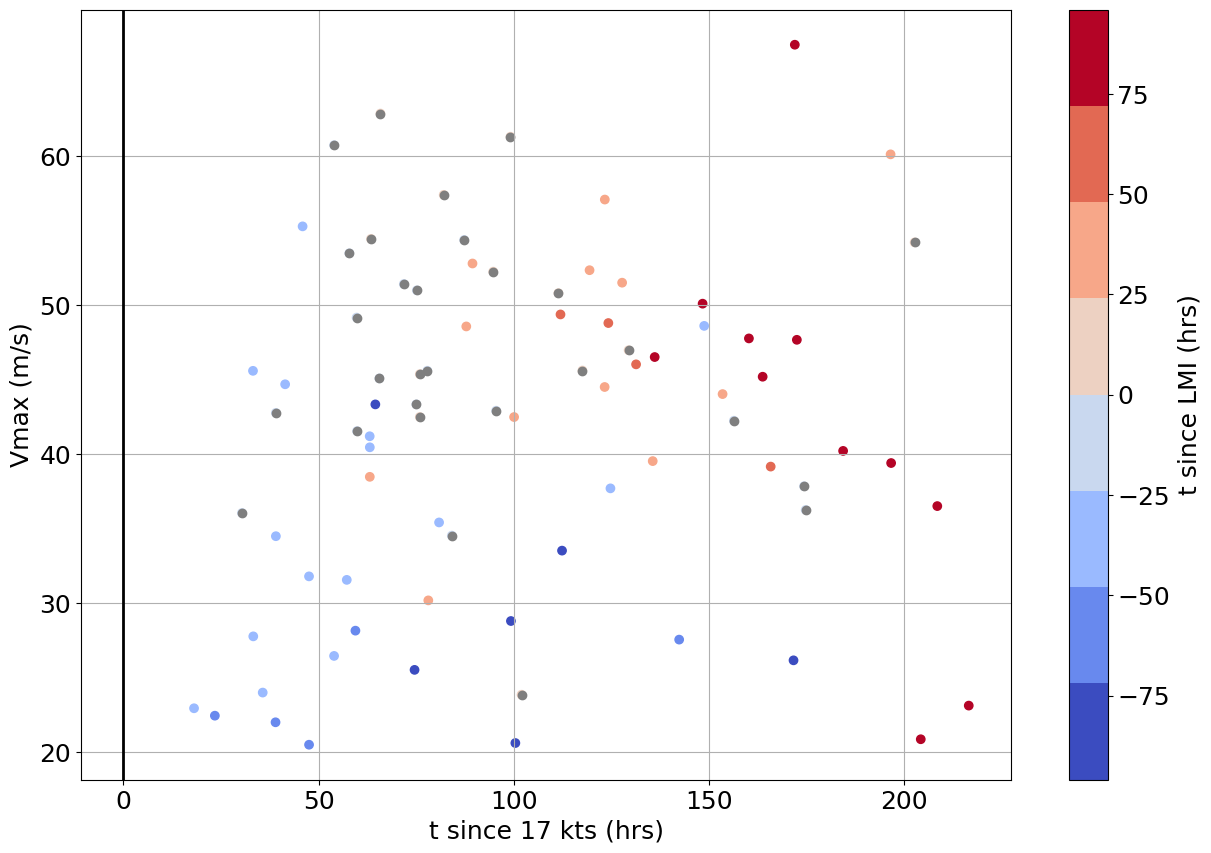

In [19]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.vmx, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.vmx, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('Vmax (m/s)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/2865457648.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rmx / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


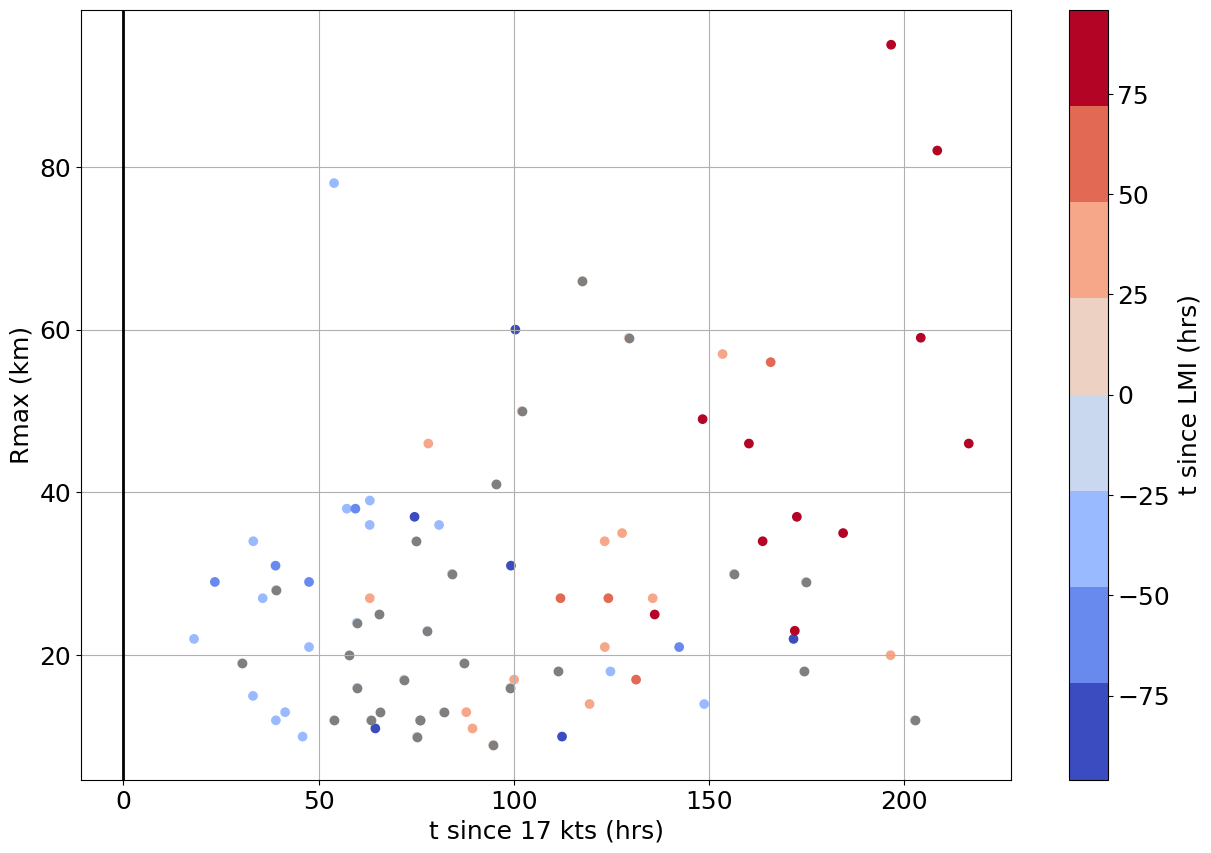

In [20]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rmx / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.rmx / 1000, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('Rmax (km)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/1330441685.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, abs(dplt.fcor), c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


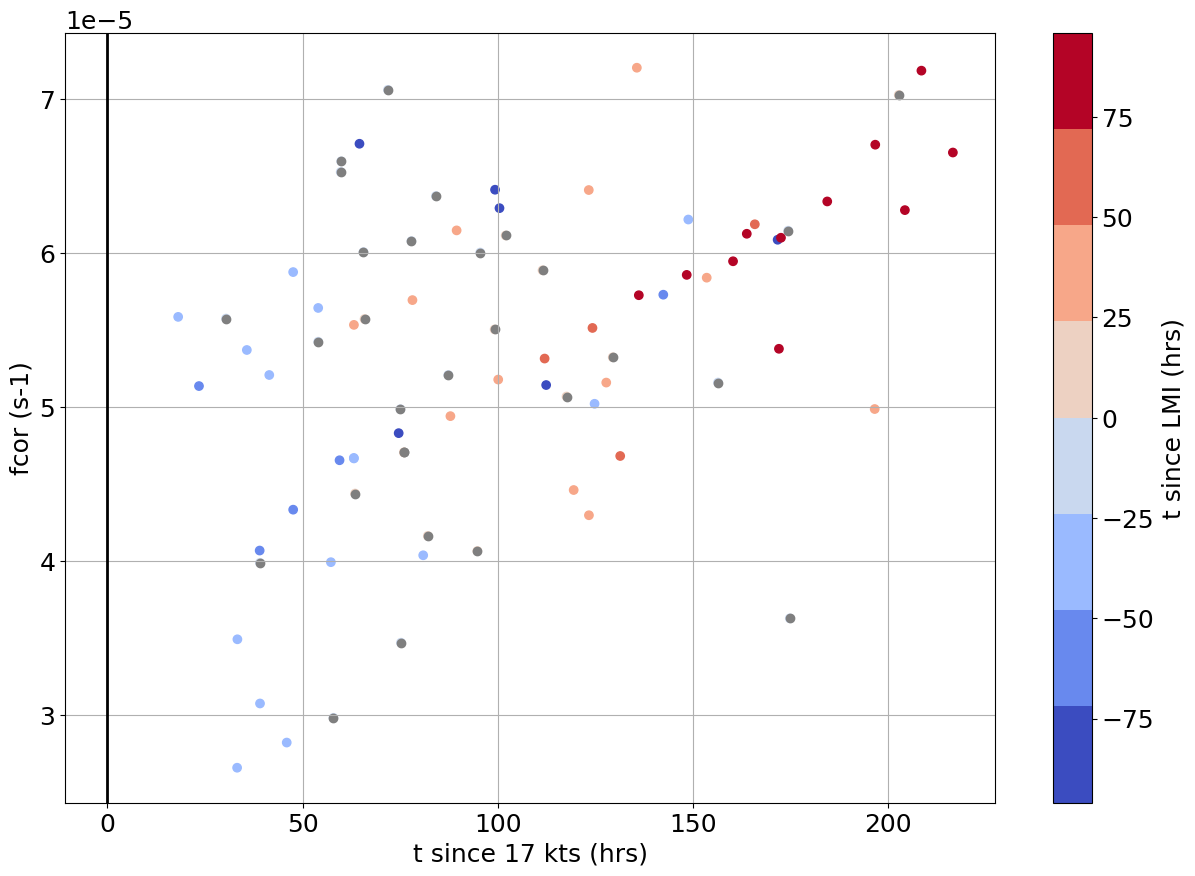

In [21]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, abs(dplt.fcor), c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, abs(dplt_lmi.fcor), c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('fcor (s-1)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/1876927534.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.r34 / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


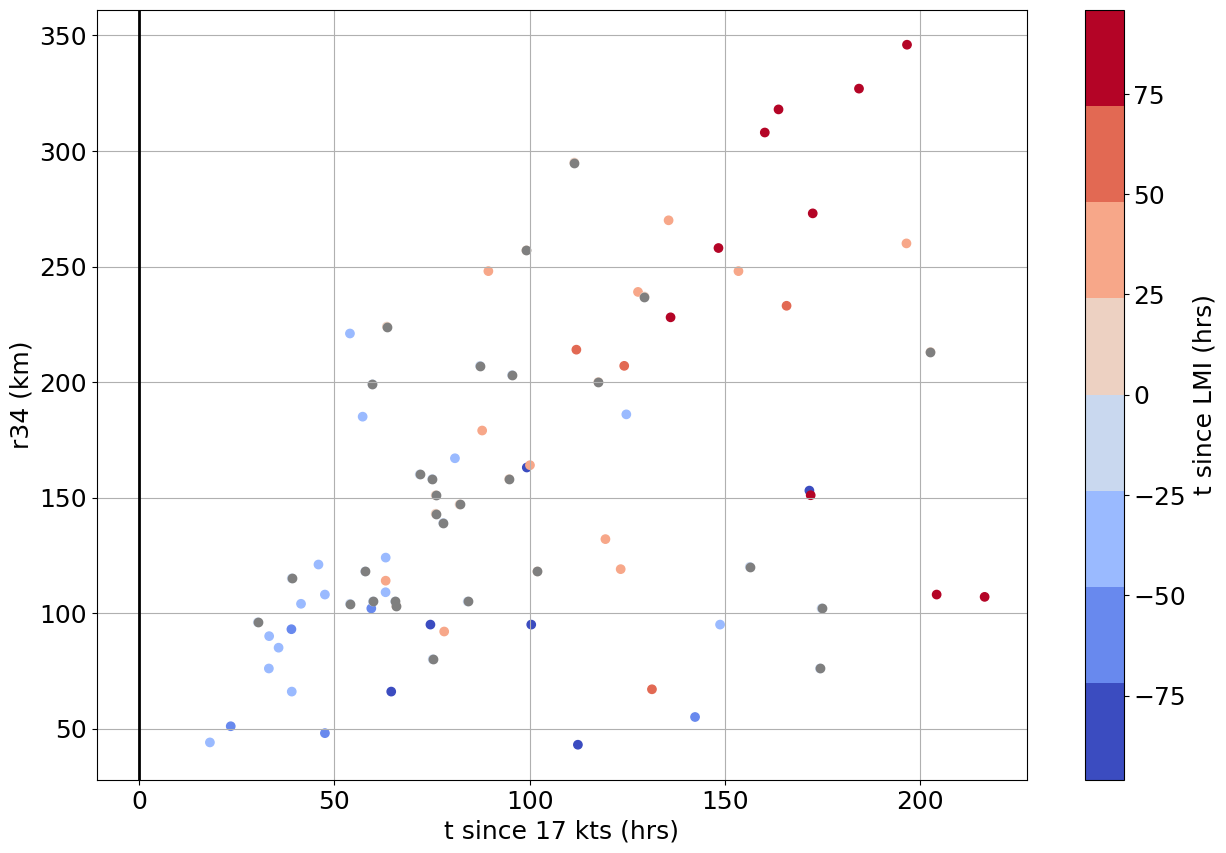

In [22]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.r34 / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.r34 / 1000, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('r34 (km)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/4144051419.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.B_hol, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


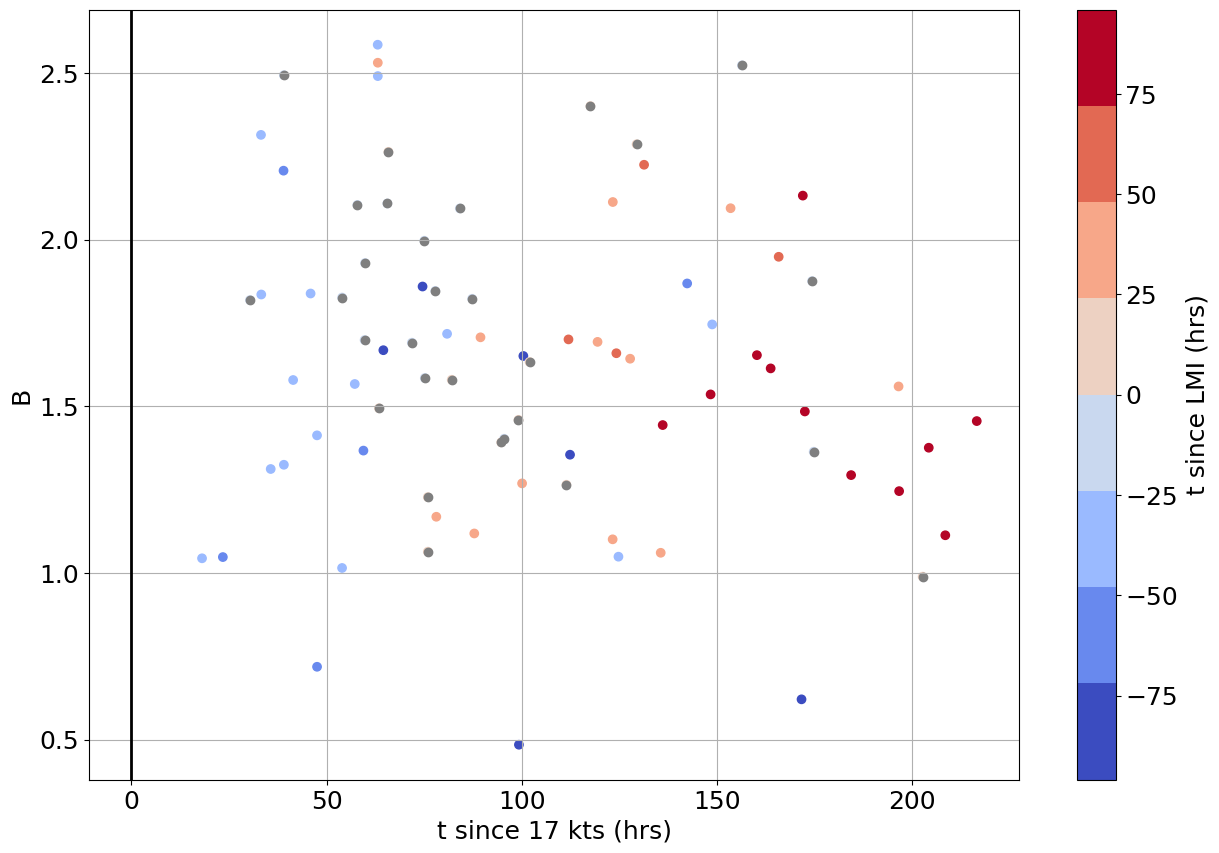

In [23]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.B_hol, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.B_hol, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('B')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/806699303.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rsby, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


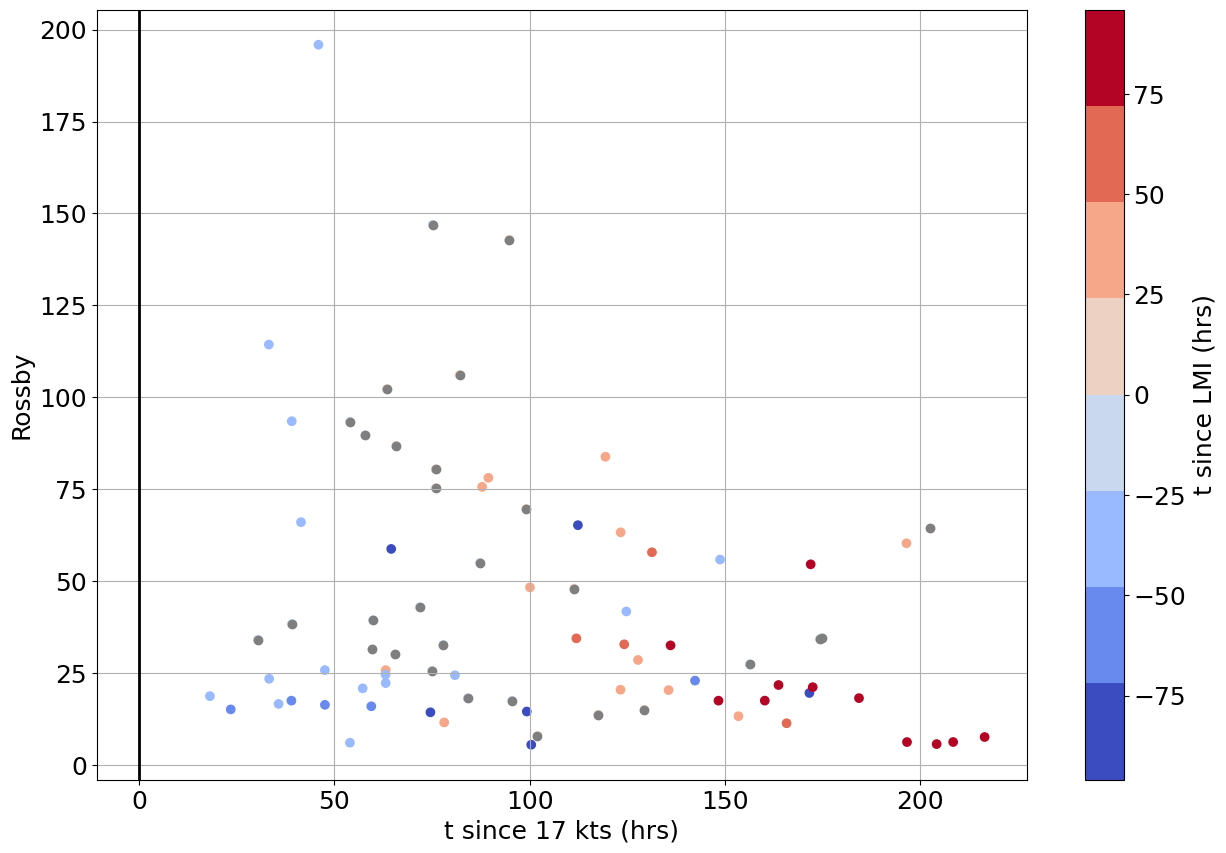

In [24]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rsby, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.rsby, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('Rossby')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/4273388779.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.uc, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


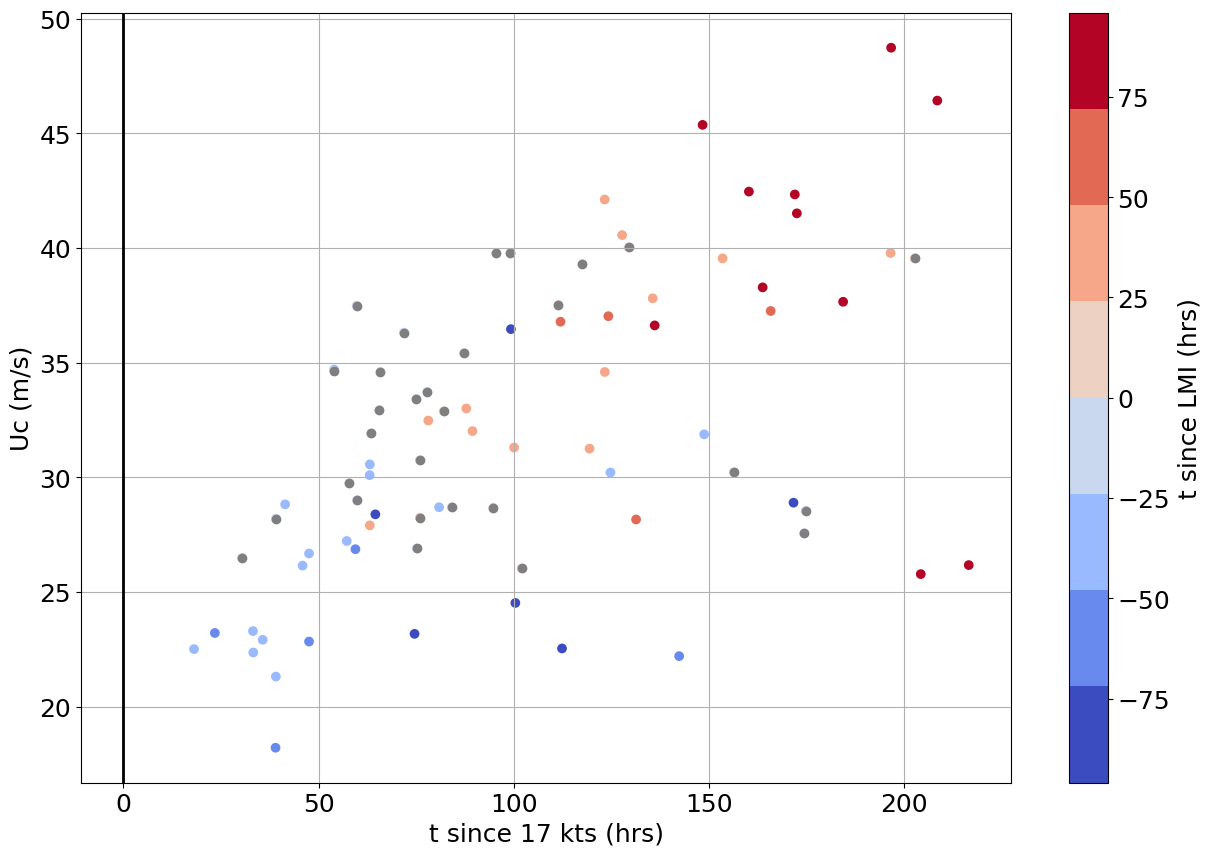

In [25]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.uc, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.uc, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('Uc (m/s)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/1927557083.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rps / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


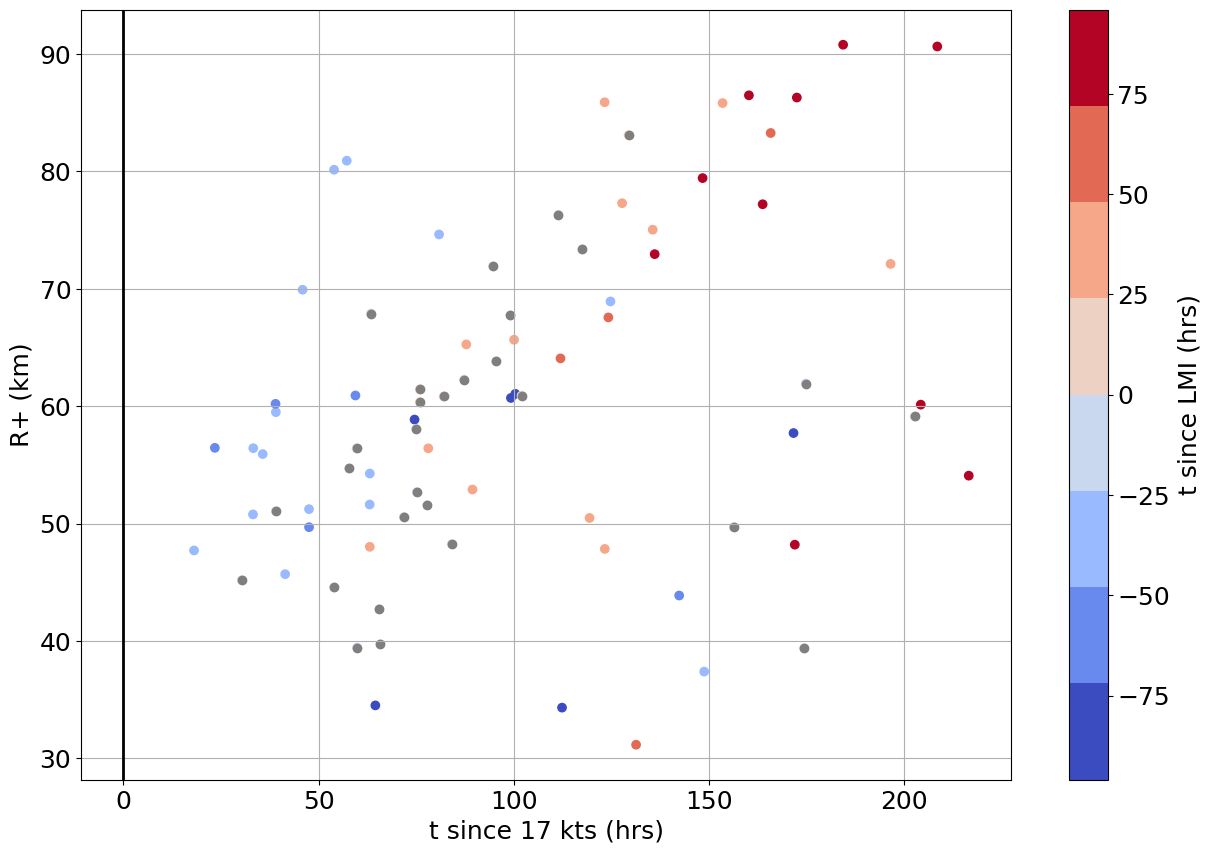

In [26]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.rps / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.rps / 1000, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('R+ (km)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

/tmp/ipykernel_56593/1911612317.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.r0 / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))


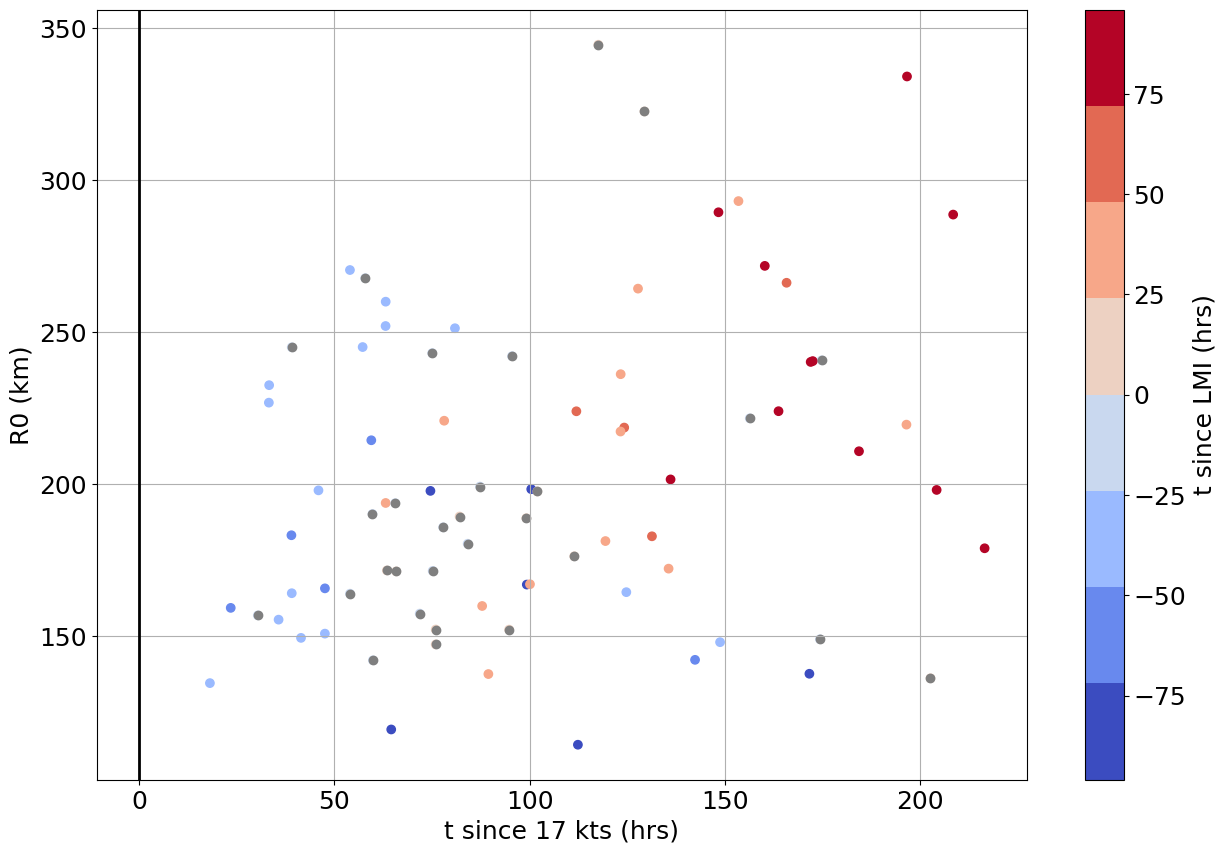

In [27]:
im = plt.scatter(dplt.t_since_17_ibt / 3600, dplt.r0 / 1000, c=dplt.t_since_lmi_ibt / 3600, vmin=-96, vmax=96, cmap=cm.get_cmap('coolwarm', 8))
plt.scatter(dplt_lmi.t_since_17_ibt / 3600, dplt_lmi.r0 / 1000, c='tab:grey')
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since 17 kts (hrs)')
plt.ylabel('R0 (km)')

cbar = plt.colorbar(im)
cbar.set_label(r't since LMI (hrs)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Test with dK/dt

Text(0, 0.5, 'B')

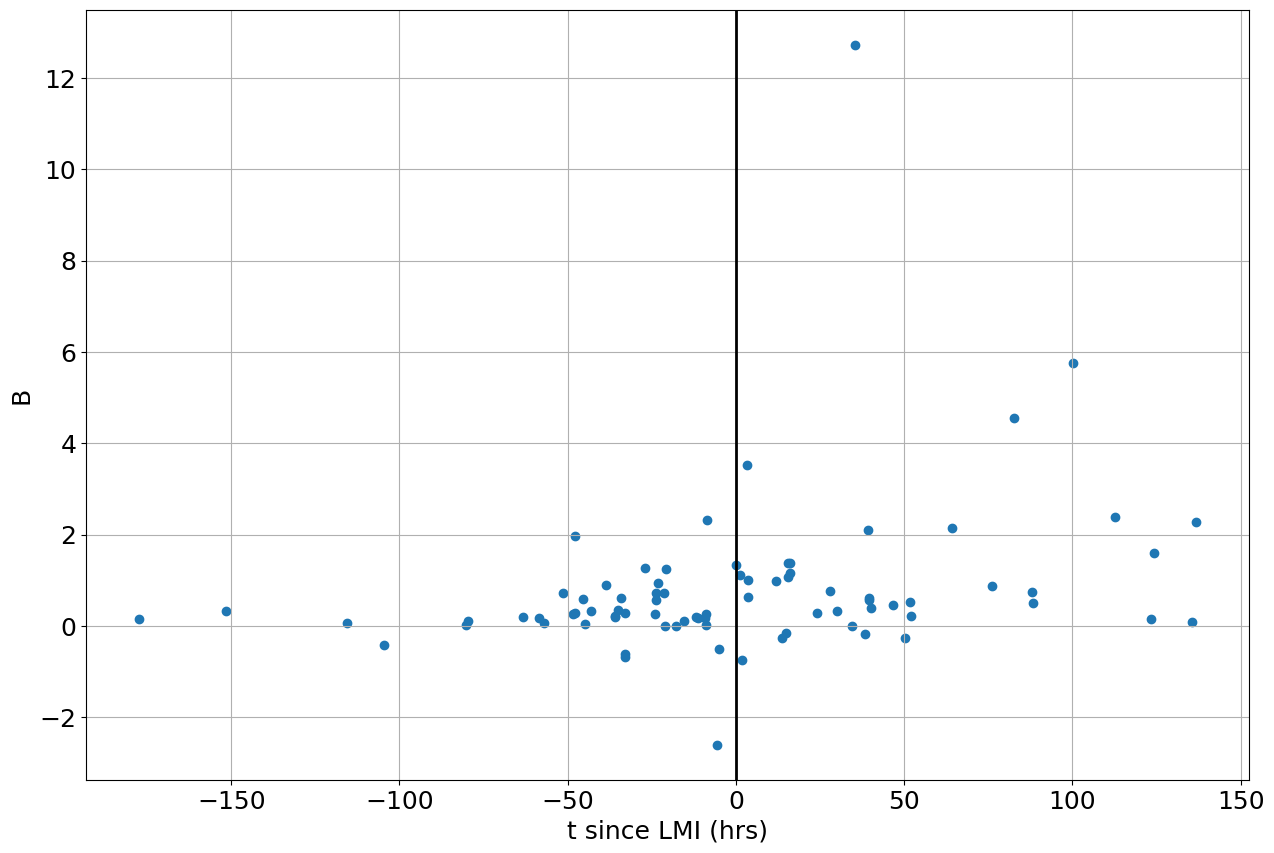

In [28]:
plt.scatter(dplt.t_since_lmi_ibt / 3600, dplt.dKdt)
plt.axvline(c='k', linewidth=2)
plt.grid()

plt.xlabel('t since LMI (hrs)')
plt.ylabel('B')

### Basin analysis by phase

In [29]:
import seaborn as sns
fontsize = 16

In [30]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

#### Pre-LMI

In [32]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

d = d.where(d.t_since_17_ibt / 3600 <= 100, drop=True)

/tmp/ipykernel_56593/2133085017.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2133085017.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


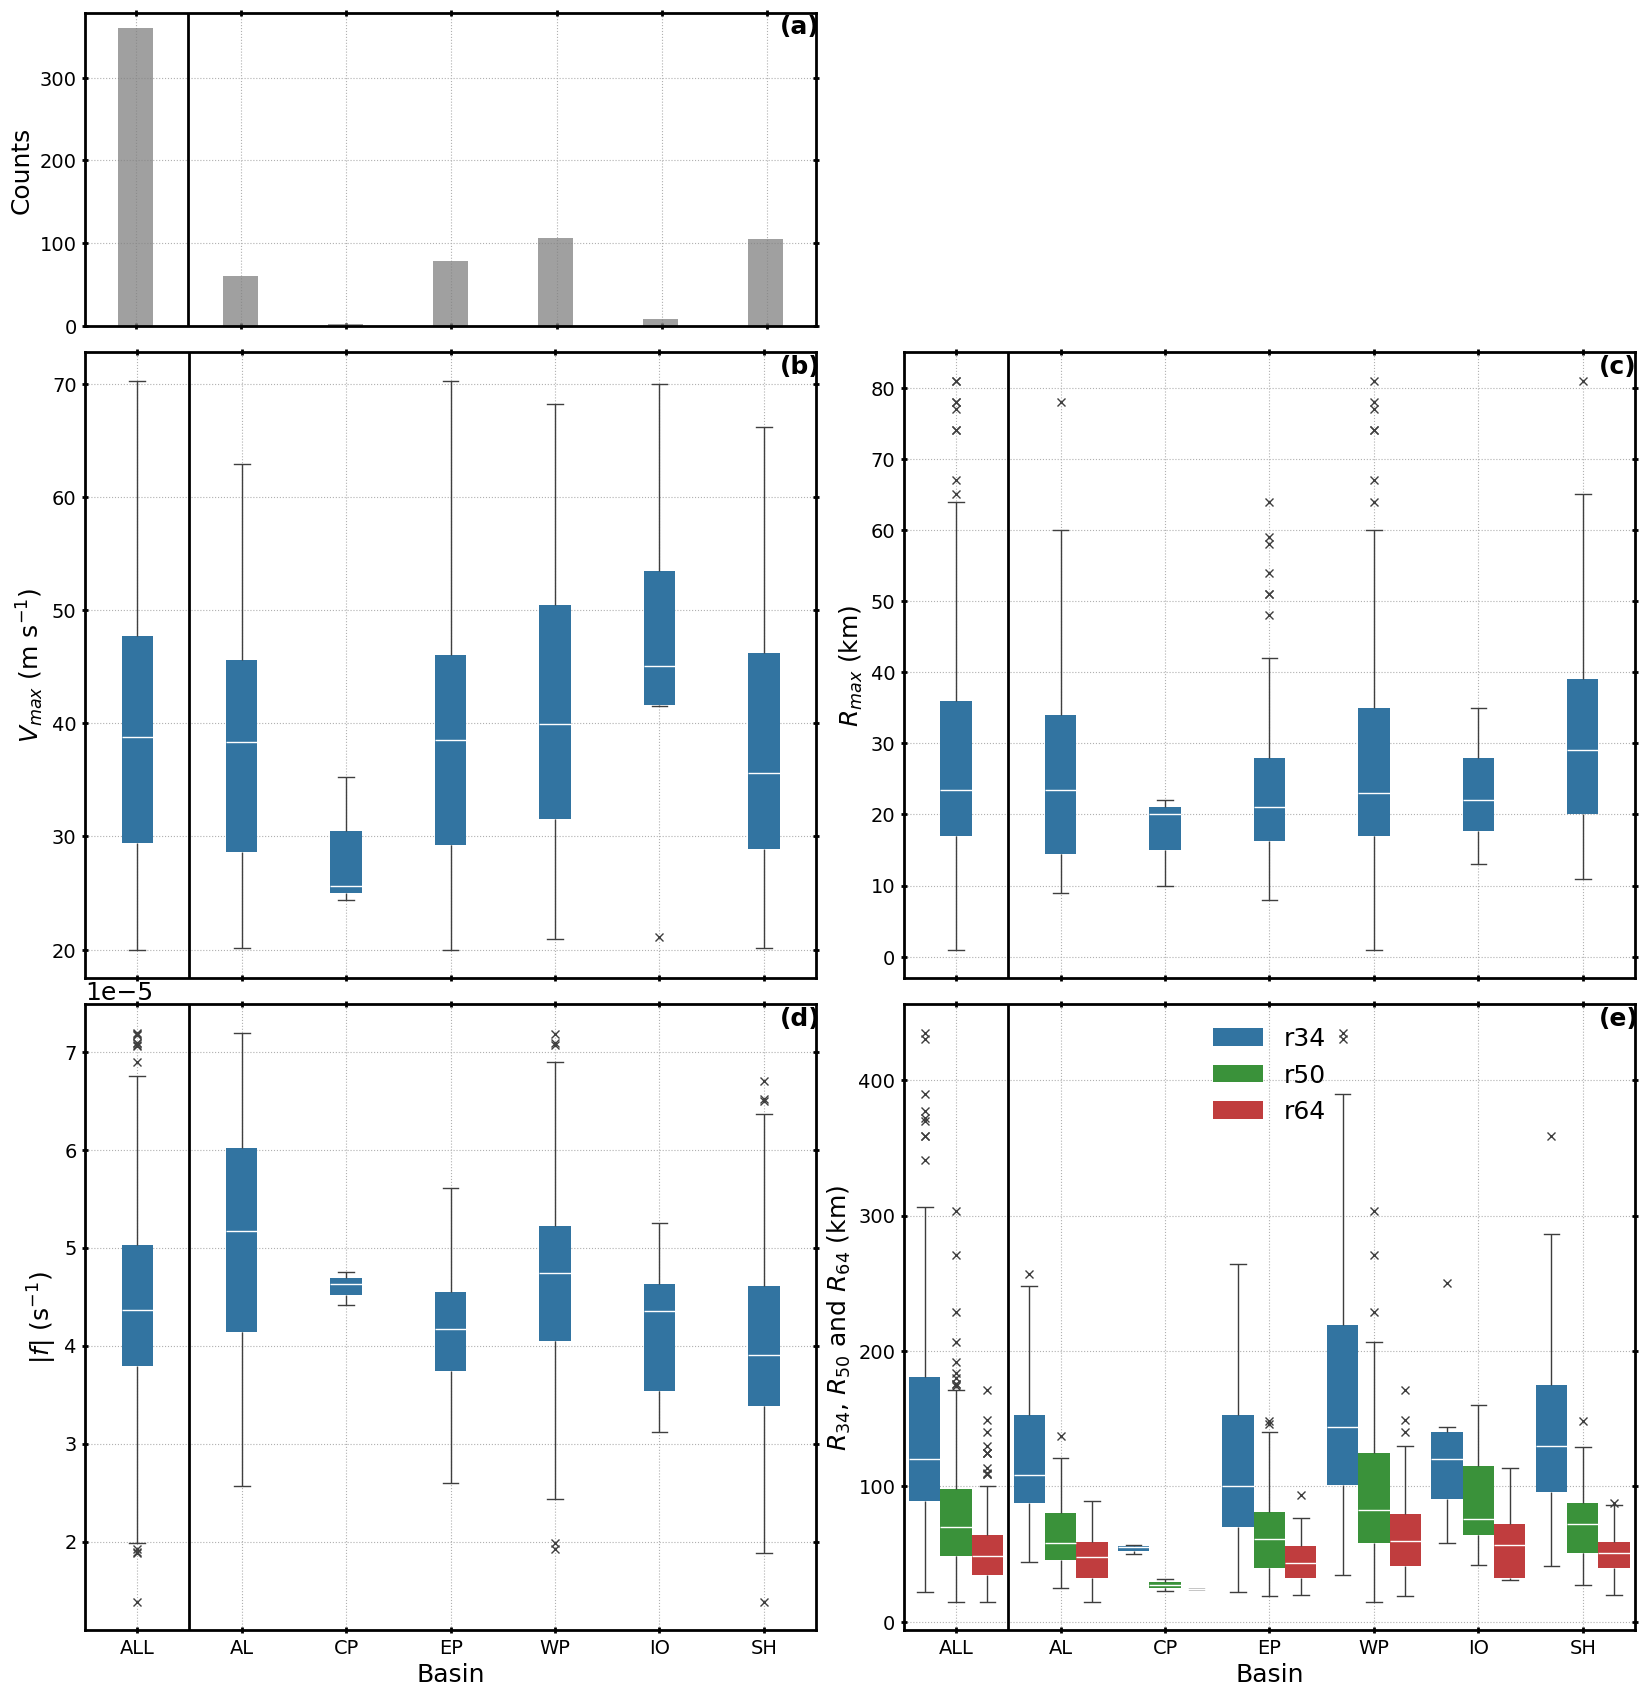

In [33]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{max}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_basin.png', bbox_inches='tight')

/tmp/ipykernel_56593/2094285578.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2094285578.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


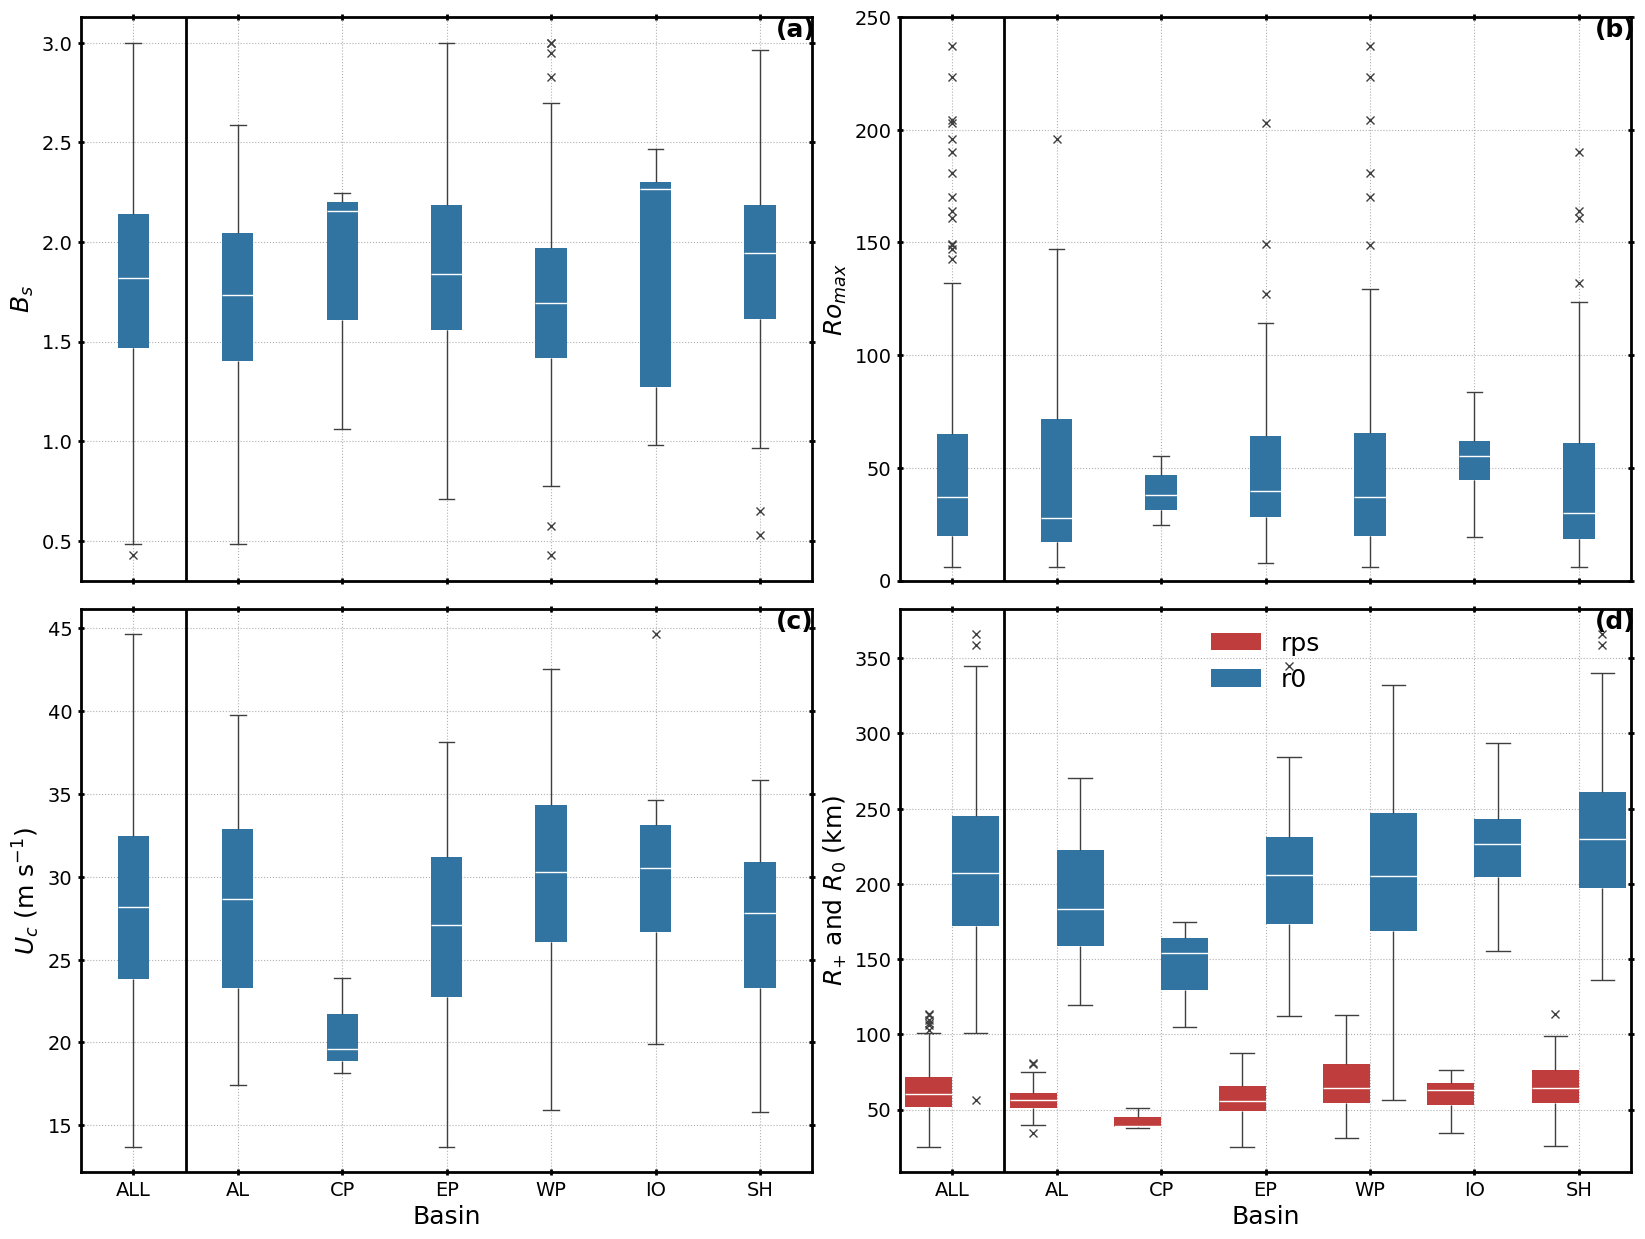

In [34]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['B_hol'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_s$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rsby'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$Ro_{max}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_c$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{+}$ and $R_{0}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_basin.png', bbox_inches='tight')

#### Post-LMI

In [37]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

d = d.where(d.t_since_17_ibt / 3600 >= 100, drop=True)

640


/tmp/ipykernel_56593/2133085017.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2133085017.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


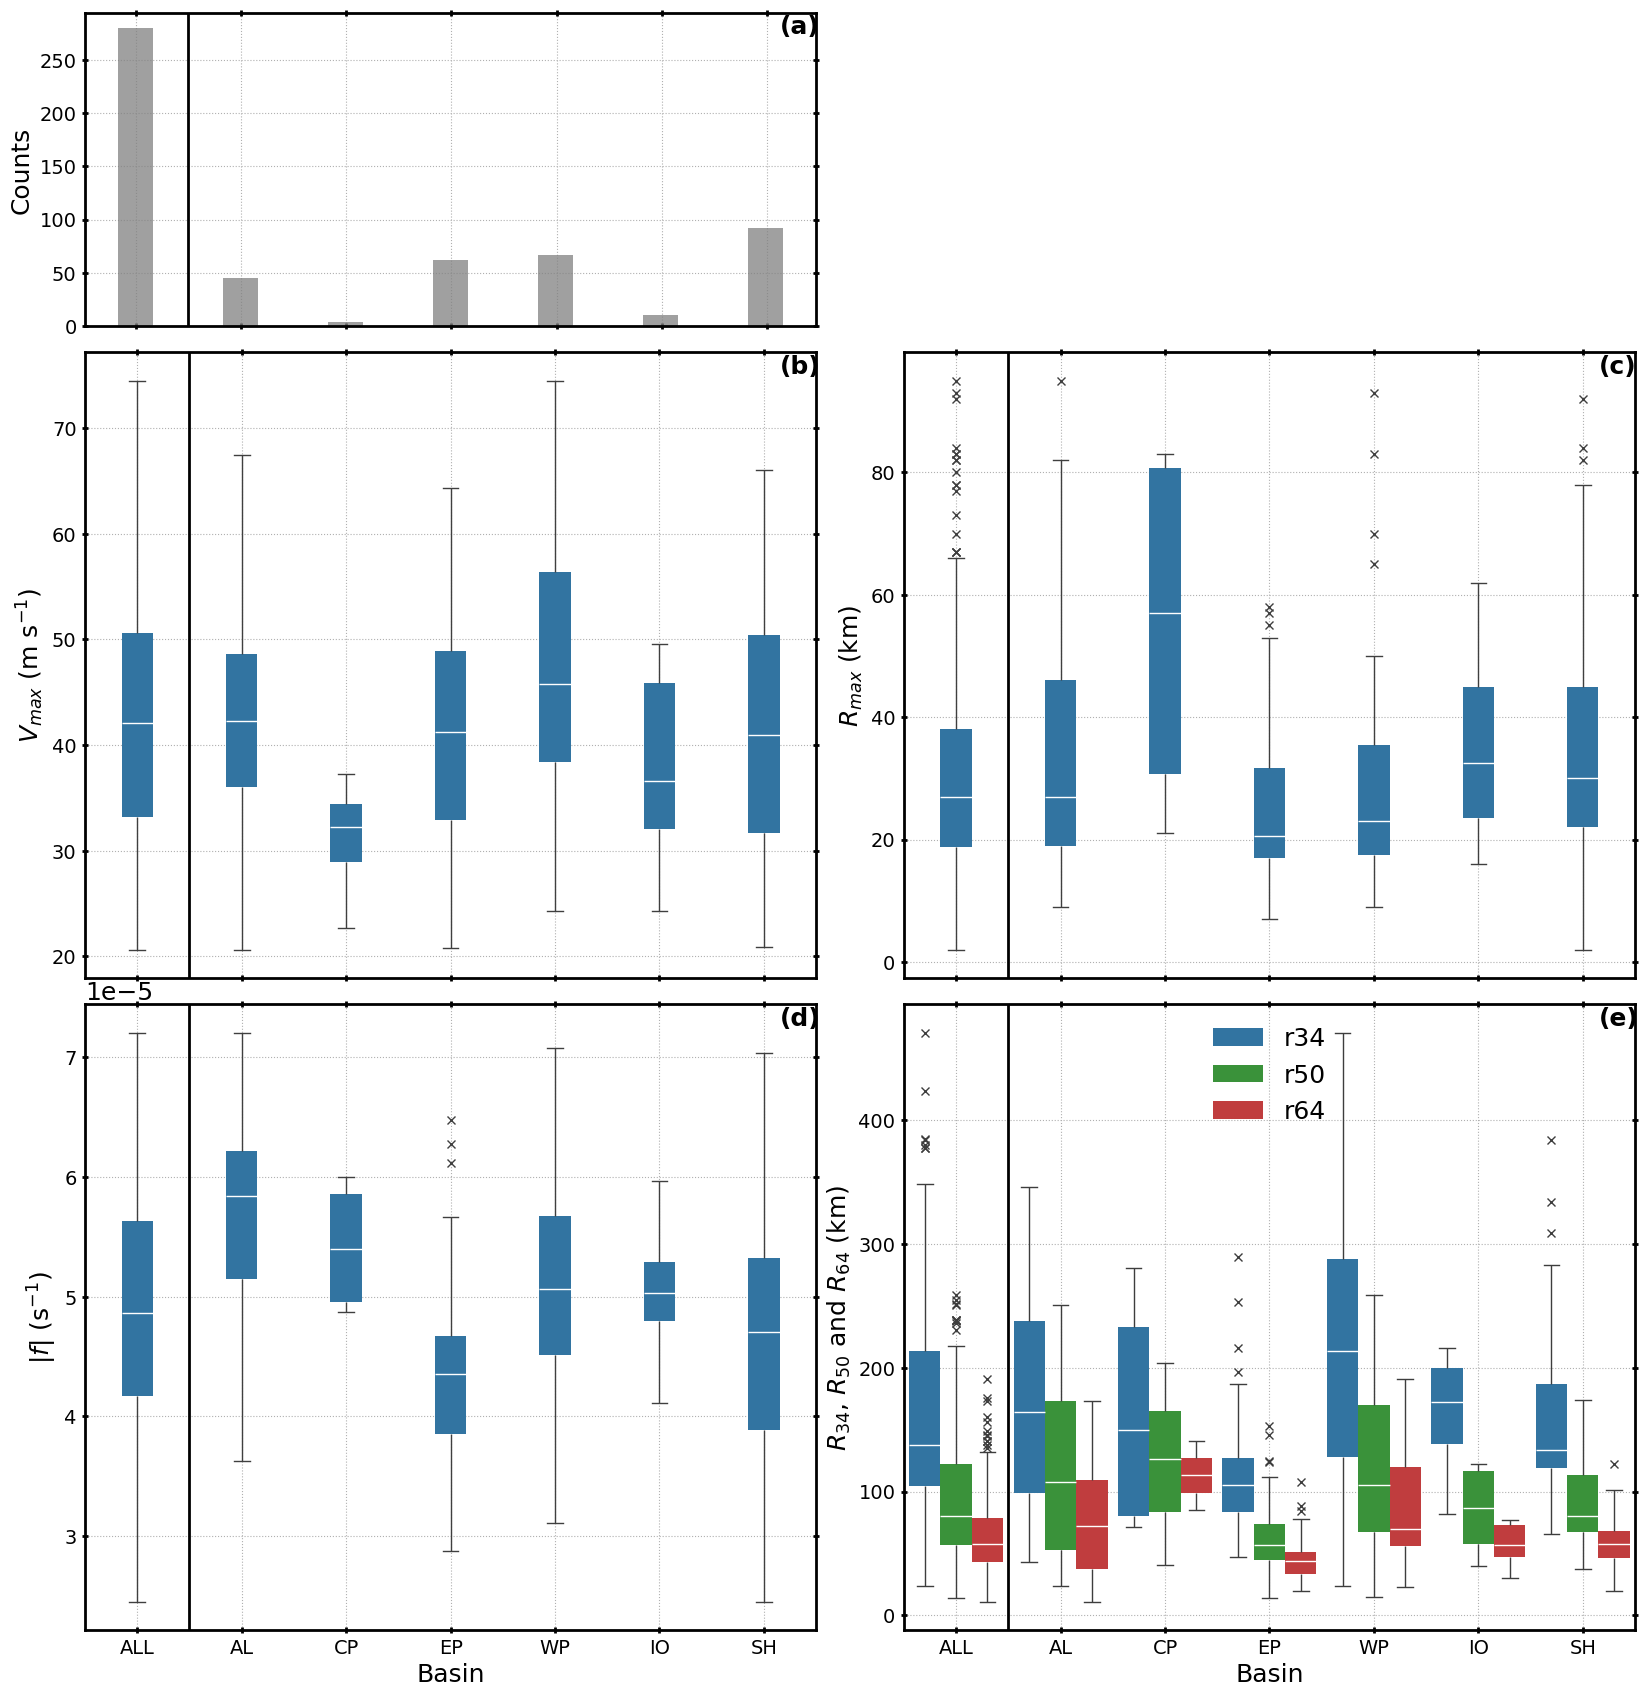

In [38]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{max}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_basin.png', bbox_inches='tight')

/tmp/ipykernel_56593/2094285578.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2094285578.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


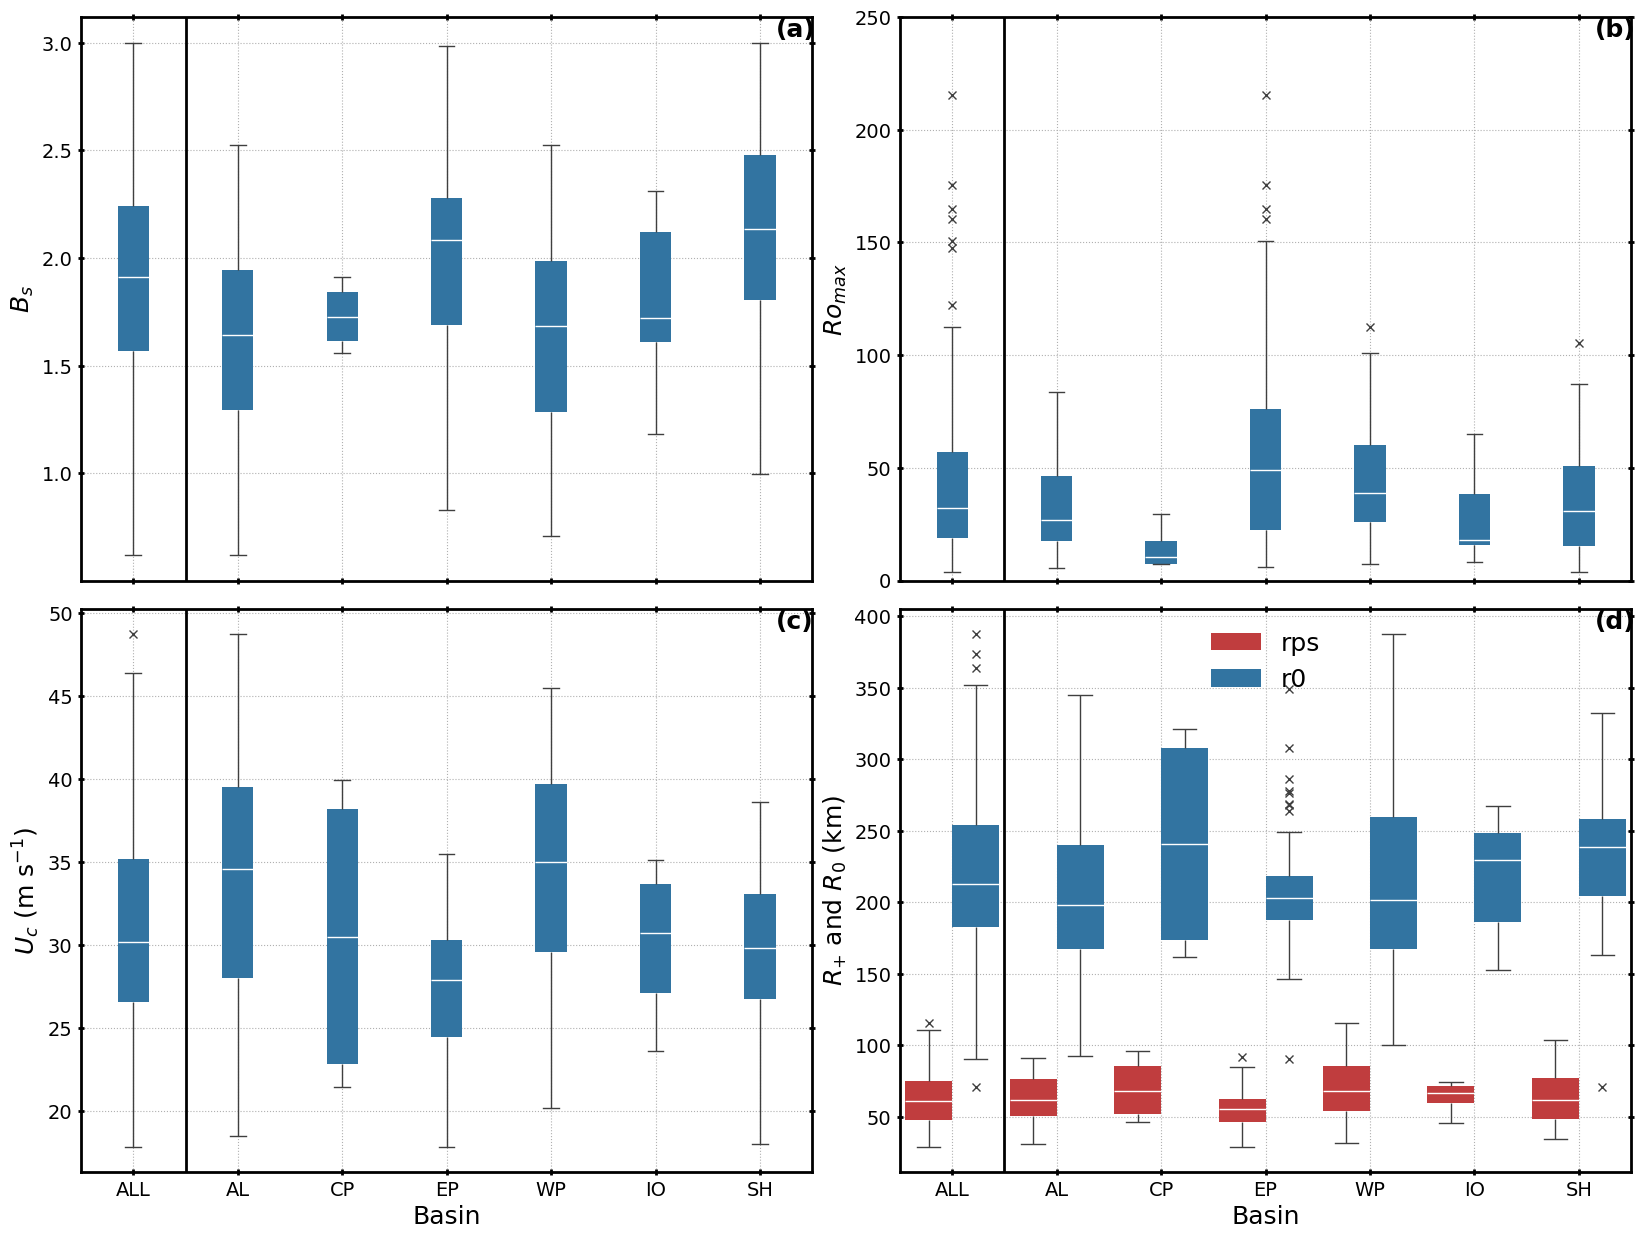

In [39]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['B_hol'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_s$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rsby'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$Ro_{max}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_c$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{+}$ and $R_{0}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_basin.png', bbox_inches='tight')

### Near-LMI

In [41]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)

d = d.where((d.t_since_lmi_ibt / 3600 >= -24) & (d.t_since_lmi_ibt / 3600 <= 24), drop=True)
print(len(d.time))

266


/tmp/ipykernel_56593/2133085017.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2133085017.py:270: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


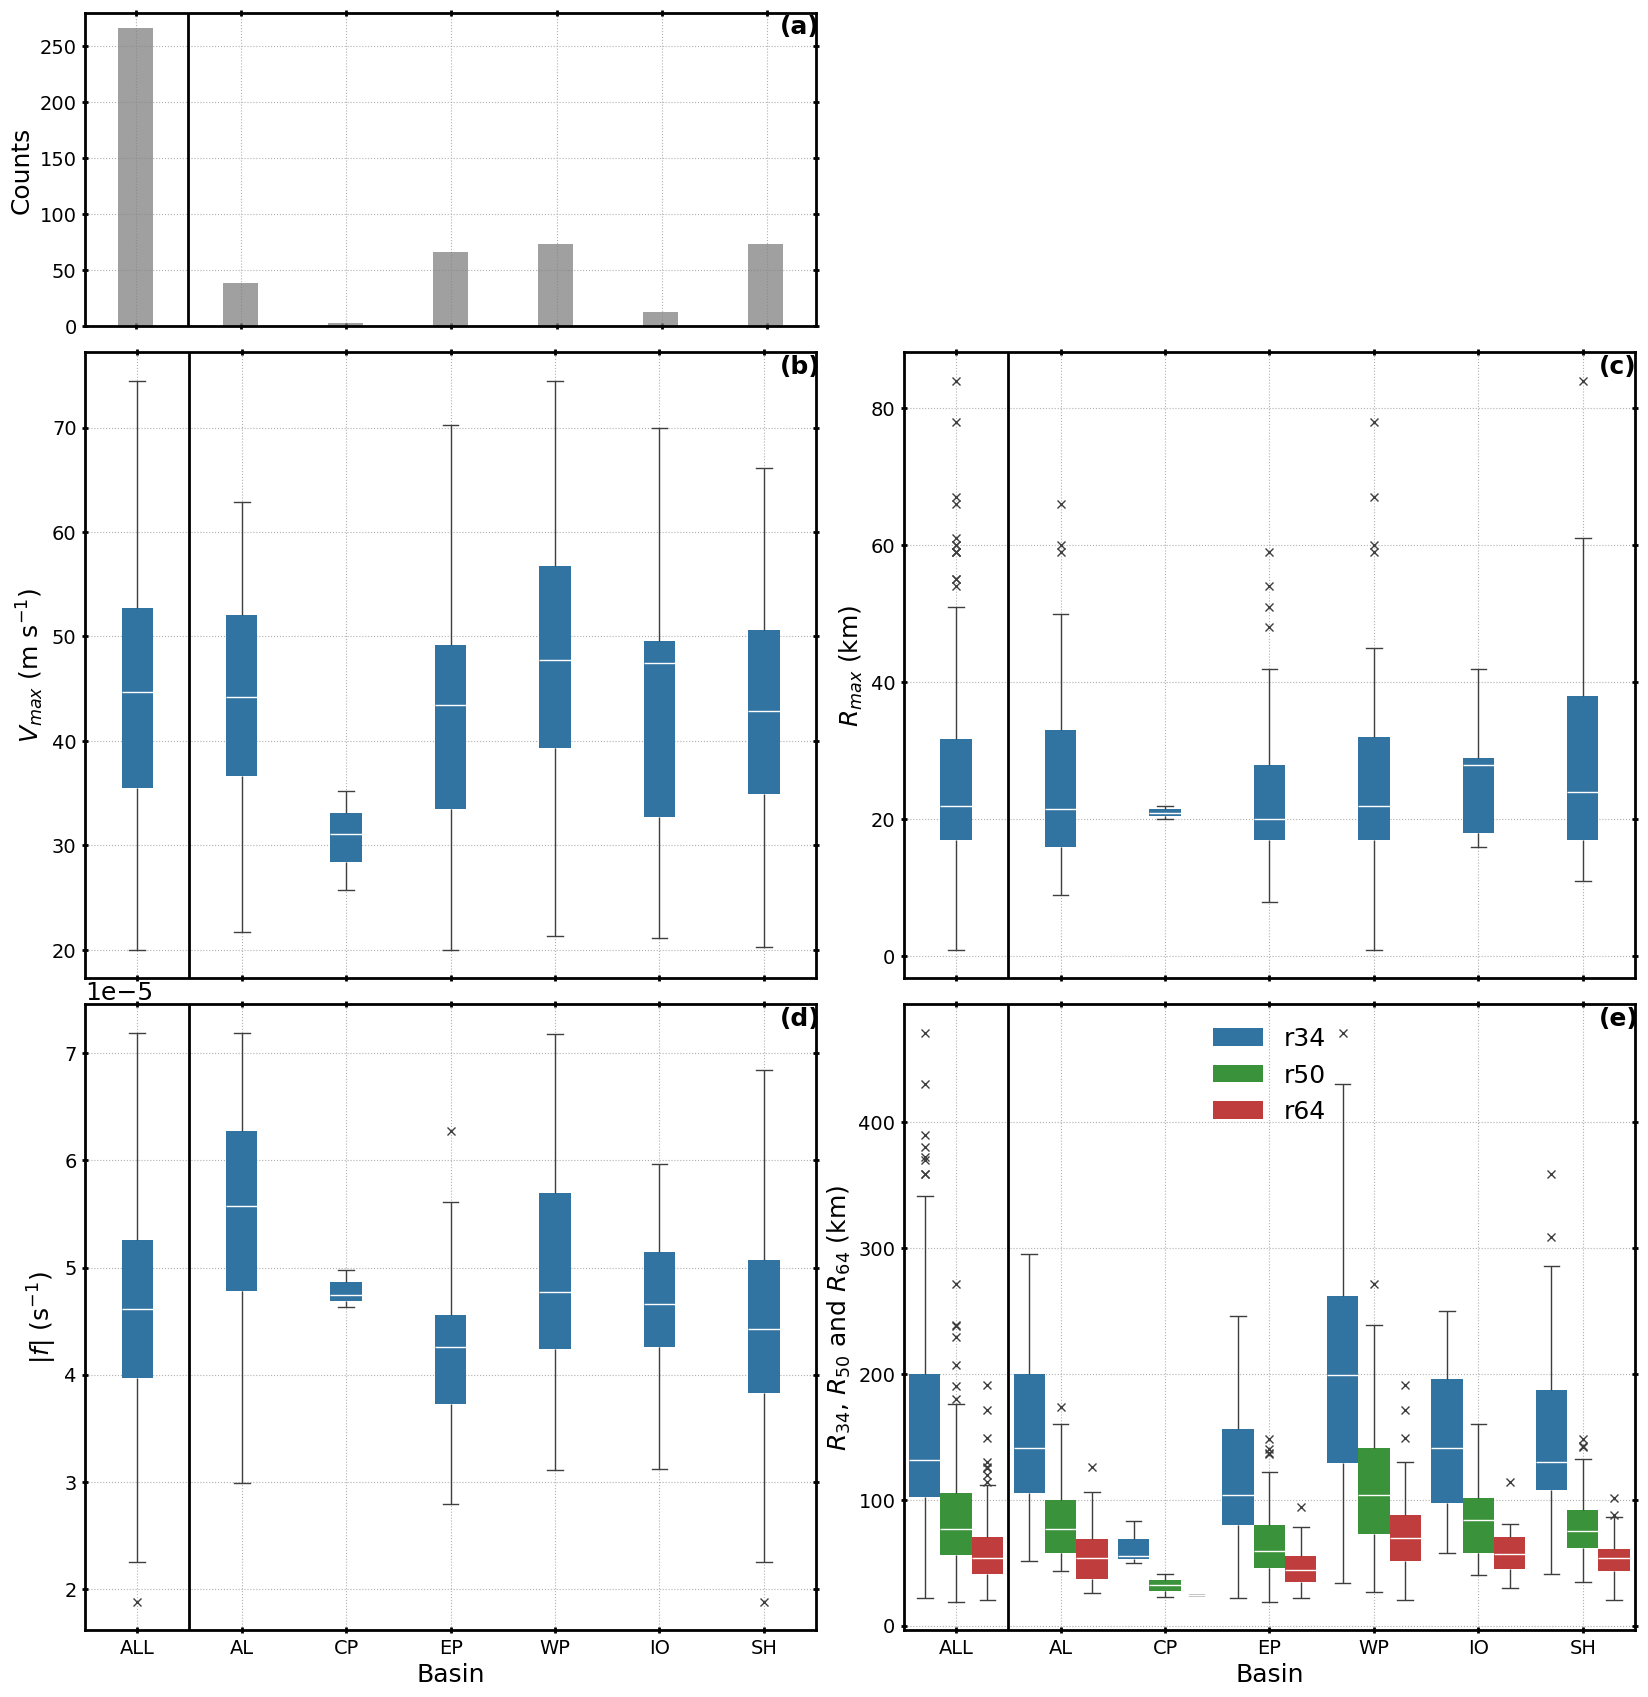

In [42]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 21))
gs         = GridSpec(3, 2, hspace=0.05, wspace=0.12, height_ratios=[1, 2, 2])

##############
### COUNTS ###
##############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.935, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])

# Boxplot
g = sns.histplot(
    data=df_combined,
    x='basin_idx',
    bins=bins,
    color='grey',
    edgecolor=None,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'Counts')
# ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### VMAX ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'vmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['vmx'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'vmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$V_{max}$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### RMAX ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rmx']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rmx'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rmx': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$R_{max}$ (km)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### FCOR ###
############
ax = fig.add_subplot(gs[2, 0])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'fcor']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['fcor'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'fcor': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$|f|$ (s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[2, 1])
ax.text(0.95, 0.965, '(e)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'r34', 'r50', 'r64']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['r34', 'r50', 'r64'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r34': color_glob, 
    'r50': 'tab:green',
    'r64': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{34}$, $R_{50}$ and $R_{64}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'best_track_prms_by_basin.png', bbox_inches='tight')

/tmp/ipykernel_56593/2094285578.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)
/tmp/ipykernel_56593/2094285578.py:220: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(xlabels)


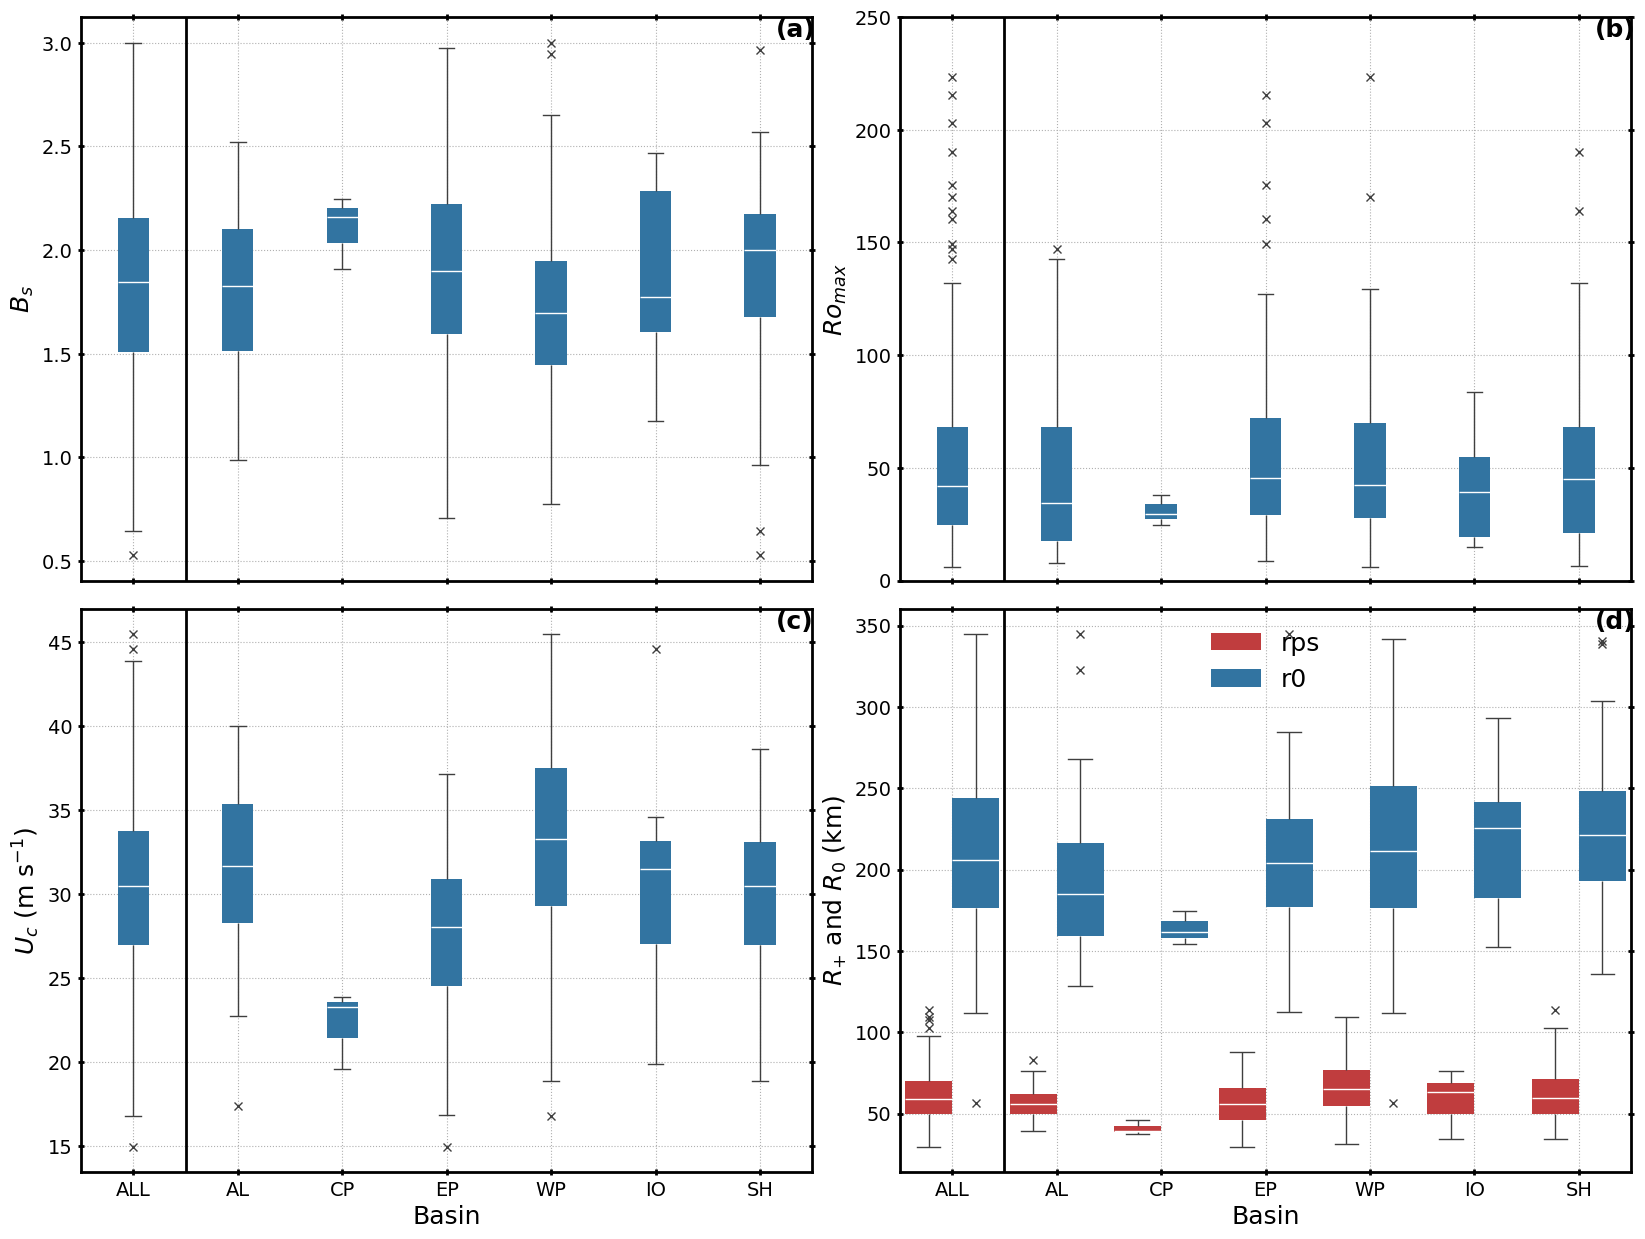

In [43]:
# Hyperparameters
width      = 0.3
bins       = np.arange(0 - width * 1.108 / 2, 6 + width * 1.108 / 2, width * 1.108)
color_glob = 'tab:blue'
color_r50  = 'tab:red'
color_r64  = 'tab:green'

# Fig.
fig        = plt.figure(figsize=(20, 15))
gs         = GridSpec(2, 2, hspace=0.05, wspace=0.12, height_ratios=[2, 2])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['B_hol'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'B_hol': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$B_s$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rsby ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rsby']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rsby'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'rsby': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
# xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
# g.set_xticklabels(xlabels)
# g.set_xlabel('Basin')
ax.set_xticklabels([])
ax.set_xlabel('')
g.set_ylabel(r'$Ro_{max}$')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

ax.set_ylim(0, 250)

############
###  Uc  ###
############
ax = fig.add_subplot(gs[1, 0])
ax.text(0.95, 0.965, '(c)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'uc']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['uc'])
df_plot['value']       = abs(df_plot['value'])
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# Colors
palette                = {'uc': color_glob}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$U_c$ (m s$^{-1}$)')
# ax.legend(frameon=False, loc='upper center')
ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

############
### Rxx  ###
############
ax = fig.add_subplot(gs[1, 1])
ax.text(0.95, 0.965, '(d)', transform=ax.transAxes, weight='bold')

# Data pre.
df                     = d[['basin_idx', 'rps', 'r0']].to_dataframe()
df_plot                = df.melt(id_vars='basin_idx', value_vars=['rps', 'r0'])
df_plot['value']       = df_plot['value'] / 1000
df_global              = df_plot.copy()
df_global['basin_idx'] = 0
df_combined            = pd.concat([df_plot, df_global])
# # Code updated because it did no longer work
df_combined            = df_combined.reset_index()
# Colors
palette = {
    'r0':  color_glob, 
    'rps': 'tab:red'
}

# Boxplot
g = sns.boxplot(
    x='basin_idx', 
    y='value', 
    hue='variable', 
    data=df_combined, 
    boxprops={'edgecolor':'none'},
    palette=palette,
    medianprops={'color': 'white'},
    flierprops=dict(marker='x', color='grey'),
    width=width * 3,
)

# Separation for All vs. basins
ax.axvline(0.5, c='k', linewidth=2)

# Labels
xlabels = [basin_keys_combined[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
g.set_xlabel('Basin')
g.set_ylabel(r'$R_{+}$ and $R_{0}$ (km)')
ax.legend(frameon=False, loc='upper center')
# ax.legend_.remove()
# Put the y ticks label ont the right 
# The same can be done to put the xlabel at the top
ax.yaxis.set_label_position("left") 
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background

# plt.savefig(PTHS['sav_dir'] + 'dynamical_prms_by_basin.png', bbox_inches='tight')